#Importar datos y librerías

In [537]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [538]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [539]:
!unzip '/content/drive/MyDrive/Colab Notebooks/oxxo_datathon2025.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/oxxo_datathon2025.zip
replace DIM_TIENDA.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: DIM_TIENDA.csv          
 extracting: DIM_TIENDA_TEST.csv     
 extracting: Meta_venta.csv          
 extracting: Venta.csv               
 extracting: diccionario_datos.xlsx  


In [540]:
df_dim_tienda = pd.read_csv('DIM_TIENDA.csv', header=0)
df_dim_tienda_test = pd.read_csv('DIM_TIENDA_TEST.csv', header=0)
df_meta_venta = pd.read_csv('Meta_venta.csv', header=0)
df_venta = pd.read_csv('Venta.csv', header=0)

#Preparación de datos

##Dataset df_dim_tienda

In [541]:
df_dim_tienda.head(5)

,TIENDA_ID,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET
0,126,1,BC,Hogar,127.42,13,7,25.69107,-100.21261,Hogar Reunión,UT_DENSIDAD,TRAIN
1,681,1,C,Hogar,128.13,13,0,25.73571,-100.18086,Hogar Reunión,UT_DENSIDAD,TRAIN
2,117,1,C,Base,87.62,11,11,25.71883,-100.19133,Hogar Reunión,UT_DENSIDAD,TRAIN
3,682,1,C,Hogar,90.70,13,0,25.66952,-100.20744,Hogar Reunión,UT_DENSIDAD,TRAIN
4,275,1,C,Hogar,95.30,13,6,25.73766,-100.16116,Hogar Reunión,UT_DENSIDAD,TRAIN


In [542]:
df_dim_tienda.columns

Index(['TIENDA_ID', 'PLAZA_CVE', 'NIVELSOCIOECONOMICO_DES', 'ENTORNO_DES',
       'MTS2VENTAS_NUM', 'PUERTASREFRIG_NUM', 'CAJONESESTACIONAMIENTO_NUM',
       'LATITUD_NUM', 'LONGITUD_NUM', 'SEGMENTO_MAESTRO_DESC',
       'LID_UBICACION_TIENDA', 'DATASET'],
      dtype='object')

In [543]:
df_dim_tienda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TIENDA_ID                   951 non-null    int64  
 1   PLAZA_CVE                   951 non-null    int64  
 2   NIVELSOCIOECONOMICO_DES     951 non-null    object 
 3   ENTORNO_DES                 951 non-null    object 
 4   MTS2VENTAS_NUM              951 non-null    float64
 5   PUERTASREFRIG_NUM           951 non-null    int64  
 6   CAJONESESTACIONAMIENTO_NUM  951 non-null    int64  
 7   LATITUD_NUM                 951 non-null    float64
 8   LONGITUD_NUM                951 non-null    float64
 9   SEGMENTO_MAESTRO_DESC       944 non-null    object 
 10  LID_UBICACION_TIENDA        951 non-null    object 
 11  DATASET                     951 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 89.3+ KB


##Dataset df_venta

###Quitar outliers inferiores

In [544]:
df_venta.columns

Index(['TIENDA_ID', 'MES_ID', 'VENTA_TOTAL'], dtype='object')

In [545]:
#crear un dataframe que muestre cantidad y porcentaje de outliers a partir de distanciarse 1.5 veces el IQR de los quartiles 1 y 3

#definir columnas de outliers
num_outliers = []
porcentaje_outliers = []

# Paso 1: Calcular Q1, Q3, y IQR por tienda
q1 = df_venta.groupby('TIENDA_ID')['VENTA_TOTAL'].transform(lambda x: x.quantile(0.25))
q3 = df_venta.groupby('TIENDA_ID')['VENTA_TOTAL'].transform(lambda x: x.quantile(0.75))
iqr = q3 - q1

# Paso 2: Calcular límites inferior y superior
limite_inferior = q1 - 1.5 * iqr

# Paso 3: Determinar si cada valor es outlier
df_venta['ES_OUTLIER_INFERIOR'] = (df_venta['VENTA_TOTAL'] < limite_inferior)
df_sin_outliers = df_venta[df_venta['ES_OUTLIER_INFERIOR'] == False]



###Agregar columna de promedio de ventas al df_dim_tienda

In [546]:
#escalar ventas
df_sin_outliers['VENTA_TOTAL'] = df_sin_outliers["VENTA_TOTAL"]*10e-6

<ipython-input-546-ff793c3a7bf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_outliers['VENTA_TOTAL'] = df_sin_outliers["VENTA_TOTAL"]*10e-6


In [547]:

df_mean_venta = df_sin_outliers.groupby('TIENDA_ID', as_index=False)['VENTA_TOTAL'].mean()
df_mean_venta_merged = pd.merge(df_mean_venta, df_dim_tienda, on='TIENDA_ID', how='right')
metas = {
    'Base': 4.8,
    'Hogar': 4.9,
    'Peatonal': 4.2,
    'Receso': 5.16
}


# Map the goals to the DataFrame based on 'ENTORNO_DES'
df_mean_venta_merged['Meta_venta'] = df_mean_venta_merged['ENTORNO_DES'].map(metas)

# Create the binary column
df_mean_venta_merged['Above_Goal'] = (df_mean_venta_merged['VENTA_TOTAL'] > df_mean_venta_merged['Meta_venta']).astype(int)

# Create the percentage column
df_mean_venta_merged['Percentage_of_Goal'] = (df_mean_venta_merged['VENTA_TOTAL'] / df_mean_venta_merged['Meta_venta']) * 100

df_mean_venta_merged[['ENTORNO_DES', 'VENTA_TOTAL', 'Meta_venta', 'Above_Goal', 'Percentage_of_Goal']]

df_mean_venta_merged = df_mean_venta_merged.dropna()

df_mean_venta_merged

,TIENDA_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET,Meta_venta,Above_Goal,Percentage_of_Goal
0,126,9.827529,1,BC,Hogar,127.42,13,7,25.69107,-100.21261,Hogar Reunión,UT_DENSIDAD,TRAIN,4.90,1,200.561818
1,681,9.019971,1,C,Hogar,128.13,13,0,25.73571,-100.18086,Hogar Reunión,UT_DENSIDAD,TRAIN,4.90,1,184.081043
2,117,4.945149,1,C,Base,87.62,11,11,25.71883,-100.19133,Hogar Reunión,UT_DENSIDAD,TRAIN,4.80,1,103.023946
3,682,9.685383,1,C,Hogar,90.70,13,0,25.66952,-100.20744,Hogar Reunión,UT_DENSIDAD,TRAIN,4.90,1,197.660881
4,275,8.594114,1,C,Hogar,95.30,13,6,25.73766,-100.16116,Hogar Reunión,UT_DENSIDAD,TRAIN,4.90,1,175.390077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,572,7.460813,6,C,Hogar,0.00,13,0,25.57330,-100.02196,Hogar Reunión,UT_DENSIDAD,TRAIN,4.90,1,152.261485
947,492,8.840135,6,B,Base,0.00,13,0,25.27251,-100.00065,Hogar Reunión,UT_TRAFICO_VEHICULAR,TRAIN,4.80,1,184.169489
948,172,13.067908,6,CD,Receso,122.70,8,0,25.19135,-99.81539,Parada Técnica,UT_CARRETERA_GAS,TRAIN,5.16,1,253.254035
949,748,9.329877,6,C,Receso,0.00,0,0,25.27433,-100.01648,Parada Técnica,UT_CARRETERA_GAS,TRAIN,5.16,1,180.811566


In [548]:
df_mean_venta_merged.isnull().sum()

,0
TIENDA_ID,0
VENTA_TOTAL,0
PLAZA_CVE,0
NIVELSOCIOECONOMICO_DES,0
ENTORNO_DES,0
MTS2VENTAS_NUM,0
PUERTASREFRIG_NUM,0
CAJONESESTACIONAMIENTO_NUM,0
LATITUD_NUM,0
LONGITUD_NUM,0


In [549]:
df_mean_venta_merged['Above_Goal'].value_counts()

,count
Above_Goal,
1,906
0,36


####Quitar columna 'DATASET' y descargar el df actualizado

In [550]:
df_mean_venta_merged.drop(columns=['DATASET'], axis=1, inplace=True)

In [551]:
# prompt: download df_mean_venta_merged

from google.colab import files

df_mean_venta_merged.to_csv('df_mean_venta_merged.csv', index=False)

###Agregar columna de promedio de ventas al df_dim_tienda_test

In [552]:
df_mean_venta = df_sin_outliers.groupby('TIENDA_ID', as_index=False)['VENTA_TOTAL'].mean()
df_mean_venta_merged = pd.merge(df_mean_venta, df_dim_tienda_test, on='TIENDA_ID', how='right')
metas = {
    'Base': 4.8,
    'Hogar': 4.9,
    'Peatonal': 4.2,
    'Receso': 5.16
}


# Map the goals to the DataFrame based on 'ENTORNO_DES'
df_mean_venta_merged['Meta_venta'] = df_mean_venta_merged['ENTORNO_DES'].map(metas)

# Create the binary column
df_mean_venta_merged['Above_Goal'] = (df_mean_venta_merged['VENTA_TOTAL'] > df_mean_venta_merged['Meta_venta']).astype(int)

# Create the percentage column
df_mean_venta_merged['Percentage_of_Goal'] = (df_mean_venta_merged['VENTA_TOTAL'] / df_mean_venta_merged['Meta_venta']) * 100

df_mean_venta_merged[['ENTORNO_DES', 'VENTA_TOTAL', 'Meta_venta', 'Above_Goal', 'Percentage_of_Goal']]

df_mean_venta_merged = df_mean_venta_merged.dropna()

df_mean_venta_merged

,TIENDA_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET,Meta_venta,Above_Goal,Percentage_of_Goal
0,680,6.503506,1,C,Hogar,102.36,13,0,25.65488,-100.21207,Hogar Reunión,UT_DENSIDAD,TEST,4.9,1,132.724610
1,730,13.839286,1,C,Hogar,97.43,14,0,25.66315,-100.22738,Hogar Reunión,UT_DENSIDAD,TEST,4.9,1,282.434400
2,650,9.598935,1,C,Hogar,117.01,13,0,25.66404,-100.22993,Hogar Reunión,UT_DENSIDAD,TEST,4.9,1,195.896637
3,670,7.959016,1,C,Base,109.76,13,0,25.66508,-100.26338,Hogar Reunión,UT_DENSIDAD,TEST,4.8,1,165.812833
4,800,5.228823,1,C,Peatonal,0.00,0,0,25.69367,-100.21433,Parada Técnica,UT_TRAFICO_PEATONAL,TEST,4.2,1,124.495791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,720,6.946310,6,C,Hogar,0.00,0,0,25.60253,-99.99317,Hogar Reunión,UT_DENSIDAD,TEST,4.9,1,141.761425
101,130,18.814206,6,CD,Base,110.06,10,0,25.36439,-100.10202,Hogar Reunión,UT_TRAFICO_VEHICULAR,TEST,4.8,1,391.962619
102,320,11.694391,6,C,Hogar,122.00,10,0,25.57214,-100.01371,Hogar Reunión,UT_TRAFICO_VEHICULAR,TEST,4.9,1,238.661050
103,510,9.491893,6,B,Hogar,0.00,13,0,25.19747,-99.83198,Hogar Reunión,UT_TRAFICO_VEHICULAR,TEST,4.9,1,193.712108


In [553]:
df_mean_venta_merged['Above_Goal'].value_counts()

,count
Above_Goal,
1,101
0,4


####Quitar columna 'DATASET' y descargar el df actualizado

In [554]:
df_mean_venta_merged.drop(columns=['DATASET'], axis=1, inplace=True)

In [555]:
# prompt: download df_mean_venta_merged


from google.colab import files

df_mean_venta_merged.to_csv('df_mean_venta_merged_test.csv', index=False)


#Preparar nuevas columnas (sociodemográficas y socioeconómicas)

In [556]:
df_tienda_limpia = pd.read_csv('df_mean_venta_merged.csv', header=0)
df_tienda_limpia_test = pd.read_csv('df_mean_venta_merged_test.csv', header=0)

In [557]:
df_tienda_limpia.columns

Index(['TIENDA_ID', 'VENTA_TOTAL', 'PLAZA_CVE', 'NIVELSOCIOECONOMICO_DES',
       'ENTORNO_DES', 'MTS2VENTAS_NUM', 'PUERTASREFRIG_NUM',
       'CAJONESESTACIONAMIENTO_NUM', 'LATITUD_NUM', 'LONGITUD_NUM',
       'SEGMENTO_MAESTRO_DESC', 'LID_UBICACION_TIENDA', 'Meta_venta',
       'Above_Goal', 'Percentage_of_Goal'],
      dtype='object')

In [558]:
df_tienda_limpia

,TIENDA_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,Meta_venta,Above_Goal,Percentage_of_Goal
0,126,9.827529,1,BC,Hogar,127.42,13,7,25.69107,-100.21261,Hogar Reunión,UT_DENSIDAD,4.90,1,200.561818
1,681,9.019971,1,C,Hogar,128.13,13,0,25.73571,-100.18086,Hogar Reunión,UT_DENSIDAD,4.90,1,184.081043
2,117,4.945149,1,C,Base,87.62,11,11,25.71883,-100.19133,Hogar Reunión,UT_DENSIDAD,4.80,1,103.023946
3,682,9.685383,1,C,Hogar,90.70,13,0,25.66952,-100.20744,Hogar Reunión,UT_DENSIDAD,4.90,1,197.660881
4,275,8.594114,1,C,Hogar,95.30,13,6,25.73766,-100.16116,Hogar Reunión,UT_DENSIDAD,4.90,1,175.390077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,572,7.460813,6,C,Hogar,0.00,13,0,25.57330,-100.02196,Hogar Reunión,UT_DENSIDAD,4.90,1,152.261485
938,492,8.840135,6,B,Base,0.00,13,0,25.27251,-100.00065,Hogar Reunión,UT_TRAFICO_VEHICULAR,4.80,1,184.169489
939,172,13.067908,6,CD,Receso,122.70,8,0,25.19135,-99.81539,Parada Técnica,UT_CARRETERA_GAS,5.16,1,253.254035
940,748,9.329877,6,C,Receso,0.00,0,0,25.27433,-100.01648,Parada Técnica,UT_CARRETERA_GAS,5.16,1,180.811566


In [559]:
df_tienda_limpia_test

,TIENDA_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,Meta_venta,Above_Goal,Percentage_of_Goal
0,680,6.503506,1,C,Hogar,102.36,13,0,25.65488,-100.21207,Hogar Reunión,UT_DENSIDAD,4.9,1,132.724610
1,730,13.839286,1,C,Hogar,97.43,14,0,25.66315,-100.22738,Hogar Reunión,UT_DENSIDAD,4.9,1,282.434400
2,650,9.598935,1,C,Hogar,117.01,13,0,25.66404,-100.22993,Hogar Reunión,UT_DENSIDAD,4.9,1,195.896637
3,670,7.959016,1,C,Base,109.76,13,0,25.66508,-100.26338,Hogar Reunión,UT_DENSIDAD,4.8,1,165.812833
4,800,5.228823,1,C,Peatonal,0.00,0,0,25.69367,-100.21433,Parada Técnica,UT_TRAFICO_PEATONAL,4.2,1,124.495791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,720,6.946310,6,C,Hogar,0.00,0,0,25.60253,-99.99317,Hogar Reunión,UT_DENSIDAD,4.9,1,141.761425
101,130,18.814206,6,CD,Base,110.06,10,0,25.36439,-100.10202,Hogar Reunión,UT_TRAFICO_VEHICULAR,4.8,1,391.962619
102,320,11.694391,6,C,Hogar,122.00,10,0,25.57214,-100.01371,Hogar Reunión,UT_TRAFICO_VEHICULAR,4.9,1,238.661050
103,510,9.491893,6,B,Hogar,0.00,13,0,25.19747,-99.83198,Hogar Reunión,UT_TRAFICO_VEHICULAR,4.9,1,193.712108


##Columna 'POBLACION'

Define la cantidad de población en la localidad del oxxo

###Importar datos y explorar datos NL

In [560]:
df_poblaciones_inegi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/conjunto_de_datos_iter_19CSV20.csv', header=0)

In [561]:
#Quedarnos con los datos relevantes
df_pob = df_poblaciones_inegi[['NOM_LOC', 'LONGITUD', 'LATITUD', 'POBTOT']]
df_pob

,NOM_LOC,LONGITUD,LATITUD,POBTOT
0,Total de la Entidad,NaN,NaN,5784442
1,Localidades de una vivienda,NaN,NaN,7782
2,Localidades de dos viviendas,NaN,NaN,3457
3,Total del Municipio,NaN,NaN,2974
4,Abasolo,"100°23'59.958"" W","25°56'43.215"" N",1992
...,...,...,...,...
4969,José Luis Ochoa,"100°26'08.459"" W","26°31'05.506"" N",6
4970,Ninguno,"100°24'33.036"" W","26°30'33.397"" N",2
4971,Los Pioneros,"100°25'32.709"" W","26°28'58.398"" N",6
4972,Localidades de una vivienda,NaN,NaN,51


In [562]:
df_pob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4974 entries, 0 to 4973
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NOM_LOC   4974 non-null   object
 1   LONGITUD  4822 non-null   object
 2   LATITUD   4822 non-null   object
 3   POBTOT    4974 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 155.6+ KB


In [563]:
df_pob.dtypes

,0
NOM_LOC,object
LONGITUD,object
LATITUD,object
POBTOT,int64


In [564]:
df_pob.columns

Index(['NOM_LOC', 'LONGITUD', 'LATITUD', 'POBTOT'], dtype='object')

###Importar datos y explorar datos TAM

In [565]:
df_poblaciones_inegi_tam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/conjunto_de_datos_iter_28CSV20_tam.csv', header=0)

In [566]:
#Quedarnos con los datos relevantes
df_pob_tam = df_poblaciones_inegi_tam[['NOM_LOC', 'LONGITUD', 'LATITUD', 'POBTOT']]
df_pob_tam

,NOM_LOC,LONGITUD,LATITUD,POBTOT
0,Total de la Entidad,NaN,NaN,3527735
1,Localidades de una vivienda,NaN,NaN,10939
2,Localidades de dos viviendas,NaN,NaN,3589
3,Total del Municipio,NaN,NaN,9822
4,Abasolo,"98°22'27.404"" W","24°03'39.012"" N",5255
...,...,...,...,...
6690,El Potrillo,"98°56'30.180"" W","22°57'34.620"" N",2
6691,El Polvorín,"98°55'38.803"" W","23°01'06.706"" N",2
6692,J. Guadalupe Rodríguez (Elder Martín Ríos Ferr...,"98°51'19.020"" W","23°01'25.130"" N",3
6693,Localidades de una vivienda,NaN,NaN,172


In [567]:
df_pob_tam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NOM_LOC   6695 non-null   object
 1   LONGITUD  6566 non-null   object
 2   LATITUD   6566 non-null   object
 3   POBTOT    6695 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 209.3+ KB


In [568]:
df_pob_tam.dtypes

,0
NOM_LOC,object
LONGITUD,object
LATITUD,object
POBTOT,int64


In [569]:
df_pob_tam.columns

Index(['NOM_LOC', 'LONGITUD', 'LATITUD', 'POBTOT'], dtype='object')

###Cambiar formato y eliminar nulos NL

In [570]:
def dms_a_decimal(dms_str):
    import re

    # Validar si es string
    if not isinstance(dms_str, str):
        return None  # o puedes devolver np.nan si usas NumPy/Pandas

    # Extraer grados, minutos, segundos y dirección (N/S/E/W)
    pattern = r'(\d+)°(\d+)\'([\d.]+)"\s*([NSEW])'
    match = re.match(pattern, dms_str.strip())

    if not match:
        raise ValueError(f"Formato incorrecto: {dms_str}")

    grados, minutos, segundos, direccion = match.groups()
    grados = int(grados)
    minutos = int(minutos)
    segundos = float(segundos)

    decimal = grados + minutos / 60 + segundos / 3600

    if direccion in ['S', 'W']:
        decimal *= -1

    return decimal


In [571]:
#aplicar al dataset
df_pob['LATITUD'] = df_pob['LATITUD'].apply(dms_a_decimal)
df_pob['LONGITUD'] = df_pob['LONGITUD'].apply(dms_a_decimal)


<ipython-input-571-4651029792f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pob['LATITUD'] = df_pob['LATITUD'].apply(dms_a_decimal)
<ipython-input-571-4651029792f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pob['LONGITUD'] = df_pob['LONGITUD'].apply(dms_a_decimal)


In [572]:
df_pob['LONGITUD'].describe()

,LONGITUD
count,4822.000000
mean,-99.895858
std,0.434911
min,-101.109240
25%,-100.177995
50%,-99.940097
75%,-99.658149
max,-98.473381


In [573]:
# Eliminar filas con coordenadas inválidas en df_pob
df_pob = df_pob.dropna(subset=['LATITUD', 'LONGITUD'])
df_pob = df_pob[np.isfinite(df_pob['LATITUD']) & np.isfinite(df_pob['LONGITUD'])]

In [574]:
df_pob[['LATITUD', 'LONGITUD']].describe()

,LATITUD,LONGITUD
count,4822.000000,4822.000000
mean,25.398073,-99.895858
std,0.804735,0.434911
min,23.247318,-101.109240
25%,24.934680,-100.177995
50%,25.400512,-99.940097
75%,25.869775,-99.658149
max,27.737707,-98.473381


###Cambiar formato y eliminar nulos TAM

In [575]:
def dms_a_decimal(dms_str):
    import re

    # Validar si es string
    if not isinstance(dms_str, str):
        return None  # o puedes devolver np.nan si usas NumPy/Pandas

    # Extraer grados, minutos, segundos y dirección (N/S/E/W)
    pattern = r'(\d+)°(\d+)\'([\d.]+)"\s*([NSEW])'
    match = re.match(pattern, dms_str.strip())

    if not match:
        raise ValueError(f"Formato incorrecto: {dms_str}")

    grados, minutos, segundos, direccion = match.groups()
    grados = int(grados)
    minutos = int(minutos)
    segundos = float(segundos)

    decimal = grados + minutos / 60 + segundos / 3600

    if direccion in ['S', 'W']:
        decimal *= -1

    return decimal


In [576]:
#aplicar al dataset
df_pob_tam['LATITUD'] = df_pob_tam['LATITUD'].apply(dms_a_decimal)
df_pob_tam['LONGITUD'] = df_pob_tam['LONGITUD'].apply(dms_a_decimal)


<ipython-input-576-4a2b3891cb4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pob_tam['LATITUD'] = df_pob_tam['LATITUD'].apply(dms_a_decimal)
<ipython-input-576-4a2b3891cb4c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pob_tam['LONGITUD'] = df_pob_tam['LONGITUD'].apply(dms_a_decimal)


In [577]:
df_pob_tam['LONGITUD'].describe()

,LONGITUD
count,6566.000000
mean,-98.571451
std,0.630958
min,-100.120343
25%,-99.093086
50%,-98.585962
75%,-97.991531
max,-97.151956


In [578]:
# Eliminar filas con coordenadas inválidas en df_pob
df_pob_tam = df_pob_tam.dropna(subset=['LATITUD', 'LONGITUD'])
df_pob_tam = df_pob_tam[np.isfinite(df_pob_tam['LATITUD']) & np.isfinite(df_pob_tam['LONGITUD'])]

In [579]:
df_pob_tam[['LATITUD', 'LONGITUD']].describe()

,LATITUD,LONGITUD
count,6566.000000,6566.000000
mean,24.426786,-98.571451
std,1.370570,0.630958
min,22.216060,-100.120343
25%,23.121044,-99.093086
50%,24.233413,-98.585962
75%,25.772185,-97.991531
max,27.664565,-97.151956


###Concatenar datasets NL y TAM

In [580]:
df_pob_completo = pd.concat([df_pob, df_pob_tam], ignore_index=True)
df_pob_completo

,NOM_LOC,LONGITUD,LATITUD,POBTOT
0,Abasolo,-100.399988,25.945338,1992
1,La Gloria,-100.380208,25.937251,7
2,La Muralla,-100.397972,25.938489,3
3,Seis de Enero (Las Bugambilias),-100.407346,25.949809,3
4,Seis de Enero,-100.408650,25.951007,2
...,...,...,...,...
11383,La Guasanga,-98.957317,23.031969,1
11384,El Mango,-99.068047,23.045728,1
11385,El Potrillo,-98.941717,22.959617,2
11386,El Polvorín,-98.927445,23.018529,2


###Hacer asignación y poner nuevos valores en nueva columna 'POBLACION'

In [581]:
coords_localidades = df_pob_completo[['LATITUD', 'LONGITUD']].to_numpy()
coords_tiendas = df_tienda_limpia[['LATITUD_NUM', 'LONGITUD_NUM']].to_numpy()
coords_tiendas_test = df_tienda_limpia_test[['LATITUD_NUM', 'LONGITUD_NUM']].to_numpy()

from scipy.spatial import cKDTree
tree = cKDTree(coords_localidades)

distancias, indices_localidad_cercana = tree.query(coords_tiendas, k=1)
df_tienda_limpia['POBLACION'] = df_pob_completo.iloc[indices_localidad_cercana].reset_index(drop=True)['POBTOT'].values

distancias_test, indices_localidad_cercana_test = tree.query(coords_tiendas_test, k=1)
df_tienda_limpia_test['POBLACION'] = df_pob_completo.iloc[indices_localidad_cercana_test].reset_index(drop=True)['POBTOT'].values

In [582]:
df_tienda_limpia['POBLACION']

,POBLACION
0,3
1,5
2,5
3,3
4,3
...,...
937,7
938,5
939,28
940,4


In [583]:
df_tienda_limpia['POBLACION'].describe()

,POBLACION
count,9.420000e+02
mean,1.460811e+05
std,2.870046e+05
min,1.000000e+00
25%,4.000000e+00
50%,2.800000e+01
75%,7.542600e+04
max,1.142952e+06


In [584]:
df_tienda_limpia_test['POBLACION']

,POBLACION
0,75426
1,635862
2,635862
3,635862
4,3
...,...
100,1
101,7
102,7
103,54467


In [585]:
df_tienda_limpia_test['POBLACION'].describe()

,POBLACION
count,1.050000e+02
mean,1.450983e+05
std,2.802719e+05
min,1.000000e+00
25%,4.000000e+00
50%,2.350000e+02
75%,7.572100e+04
max,1.142952e+06


##Columna 'COMPETIDORES_NUM'

In [586]:
import geopandas as gpd
# Leer el archivo descargado
gdf_competidores = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/competidores.geojson")

# Asegúrate de tener columnas LAT y LON
df_competidores = pd.DataFrame({
    "lat": gdf_competidores.geometry.y,
    "lon": gdf_competidores.geometry.x
})

In [587]:
df_competidores.drop_duplicates(inplace=True)
df_competidores.head(5)

,lat,lon
0,25.711965,-100.361257
1,25.606947,-100.268310
2,25.785015,-100.253146
3,25.646302,-100.292510
4,25.650963,-100.292478


In [588]:
from sklearn.neighbors import BallTree

# Convertir grados a radianes
tiendas_coords = np.radians(df_tienda_limpia[['LATITUD_NUM', 'LONGITUD_NUM']])
tiendas_coords_test = np.radians(df_tienda_limpia_test[['LATITUD_NUM', 'LONGITUD_NUM']])
competidor_coords = np.radians(df_competidores[['lat', 'lon']])

# Crear el árbol con competidores
tree = BallTree(competidor_coords, metric='haversine')

# Buscar competidores en un radio de 600 m (0.6 km)
radio_km = 0.6
radio_radianes = radio_km / 6371.0  # Radio de la Tierra en km

# Para cada tienda, contar competidores dentro de 600 m
conteos = tree.query_radius(tiendas_coords, r=radio_radianes, count_only=True)
conteos_test = tree.query_radius(tiendas_coords_test, r=radio_radianes, count_only=True)

# Crear la nueva columna en df_tienda_limpia
df_tienda_limpia["COMPETIDORES_NUM"] = conteos
df_tienda_limpia_test["COMPETIDORES_NUM"] = conteos_test

In [589]:
df_tienda_limpia["COMPETIDORES_NUM"]

,COMPETIDORES_NUM
0,4
1,0
2,5
3,1
4,1
...,...
937,0
938,1
939,1
940,2


In [590]:
df_tienda_limpia["COMPETIDORES_NUM"].describe()

,COMPETIDORES_NUM
count,942.000000
mean,1.116773
std,1.450257
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,11.000000


In [591]:
df_tienda_limpia_test["COMPETIDORES_NUM"]

,COMPETIDORES_NUM
0,0
1,1
2,1
3,0
4,6
...,...
100,0
101,1
102,0
103,0


In [592]:
df_tienda_limpia_test["COMPETIDORES_NUM"].describe()

,COMPETIDORES_NUM
count,105.000000
mean,0.904762
std,1.410972
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,7.000000


##Columnas 'ESCUELAS_NUM' y 'HOSPITALES_NUM'

In [593]:
# Leer el archivo descargado
gdf_escuelas_hospitales = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/escuelas_hospitales.geojson")

# Asegúrate de tener columnas LAT y LON
df_escuelas_hospitales = pd.DataFrame({
    "amenity": gdf_escuelas_hospitales.amenity,
    "lat": gdf_escuelas_hospitales.geometry.y,
    "lon": gdf_escuelas_hospitales.geometry.x
})

In [594]:
df_escuelas_hospitales.drop_duplicates(inplace=True)
df_escuelas_hospitales.head(5)

,amenity,lat,lon
0,school,25.691343,-100.496592
1,school,25.680965,-100.480397
2,hospital,25.194824,-99.842163
3,hospital,25.681501,-100.318526
4,school,25.676492,-100.366956


In [595]:
# Convertir grados a radianes
tiendas_coords = np.radians(df_tienda_limpia[['LATITUD_NUM', 'LONGITUD_NUM']])
tiendas_coords_test = np.radians(df_tienda_limpia_test[['LATITUD_NUM', 'LONGITUD_NUM']])
escuelas_coords = np.radians(df_escuelas_hospitales[df_escuelas_hospitales['amenity'] == 'school'][['lat', 'lon']])
hospitales_coords = np.radians(df_escuelas_hospitales[df_escuelas_hospitales['amenity'] == 'hospital'][['lat', 'lon']])

# Crear los árboles con escuelas y hospitales
tree_escuelas = BallTree(escuelas_coords, metric='haversine')
tree_hospitales = BallTree(hospitales_coords, metric='haversine')

# Buscar competidores en un radio de 600 m (0.6 km)
radio_km = 0.6
radio_radianes = radio_km / 6371.0  # Radio de la Tierra en km

# Para cada tienda, contar escuelas y hospitales dentro de 600 m
conteos_escuelas = tree_escuelas.query_radius(tiendas_coords, r=radio_radianes, count_only=True)
conteos_hospitales = tree_hospitales.query_radius(tiendas_coords, r=radio_radianes, count_only=True)
conteos_escuelas_test = tree_escuelas.query_radius(tiendas_coords_test, r=radio_radianes, count_only=True)
conteos_hospitales_test = tree_hospitales.query_radius(tiendas_coords_test, r=radio_radianes, count_only=True)

# Crear las nuevas columnas en df_tienda_limpia
df_tienda_limpia["ESCUELAS_NUM"] = conteos_escuelas
df_tienda_limpia["HOSPITALES_NUM"] = conteos_hospitales
df_tienda_limpia_test["ESCUELAS_NUM"] = conteos_escuelas_test
df_tienda_limpia_test["HOSPITALES_NUM"] = conteos_hospitales_test

In [596]:
df_tienda_limpia[["ESCUELAS_NUM", "HOSPITALES_NUM"]]

,ESCUELAS_NUM,HOSPITALES_NUM
0,1,0
1,0,0
2,2,0
3,4,0
4,6,0
...,...,...
937,0,0
938,1,0
939,0,0
940,0,2


In [597]:
df_tienda_limpia[["ESCUELAS_NUM", "HOSPITALES_NUM"]].describe()

,ESCUELAS_NUM,HOSPITALES_NUM
count,942.000000,942.000000
mean,1.229299,0.192144
std,1.723277,0.545703
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.000000
max,9.000000,5.000000


In [598]:
df_tienda_limpia_test[["ESCUELAS_NUM", "HOSPITALES_NUM"]]

,ESCUELAS_NUM,HOSPITALES_NUM
0,5,0
1,5,0
2,6,0
3,1,0
4,1,0
...,...,...
100,0,0
101,0,0
102,0,0
103,1,0


In [599]:
df_tienda_limpia_test[["ESCUELAS_NUM", "HOSPITALES_NUM"]].describe()

,ESCUELAS_NUM,HOSPITALES_NUM
count,105.000000,105.000000
mean,1.142857,0.095238
std,1.728876,0.354200
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.000000
max,6.000000,2.000000


#Guardar csv nuevos

In [600]:
#quitar 0s en latitudes de df_tienda_limpia
df_tienda_limpia = df_tienda_limpia[df_tienda_limpia['LATITUD_NUM'] != 0]

In [601]:
from google.colab import files

df_tienda_limpia.to_csv('df_tienda_limpia.csv', index=False)

df_tienda_limpia_test.to_csv('df_tienda_limpia_test.csv', index=False)

#Exploración de datos

##Importar datos

In [602]:
#Importar los dataframes df_tienda_limpia y df_tienda_limpia_test
df_tienda_limpia = pd.read_csv('df_tienda_limpia.csv', header=0)
df_tienda_limpia_test = pd.read_csv('df_tienda_limpia_test.csv', header=0)

##Variables numéricas

###Variable 'Percentage_of_Goal'

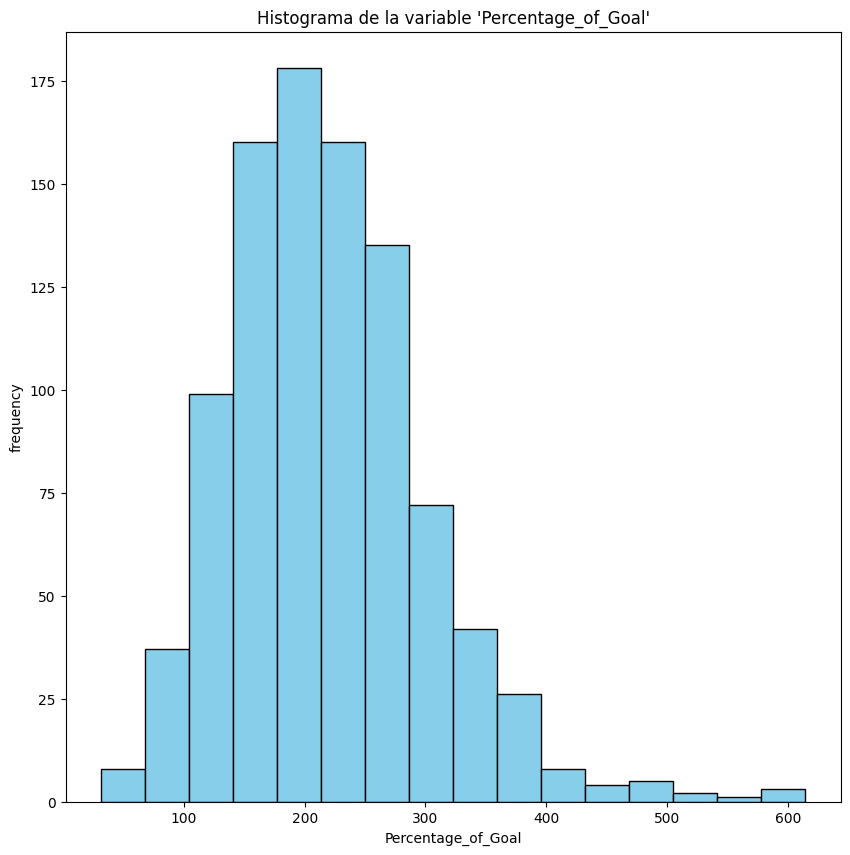

In [603]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['Percentage_of_Goal'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'Percentage_of_Goal'")
plt.xlabel("Percentage_of_Goal")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

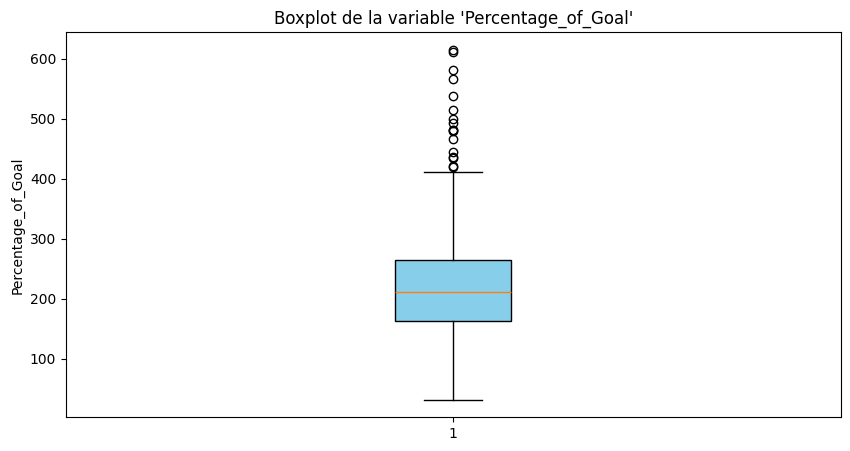

In [604]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['Percentage_of_Goal'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'Percentage_of_Goal'")
plt.ylabel("Percentage_of_Goal")
plt.show()

###Variable 'VENTA_TOTAL'

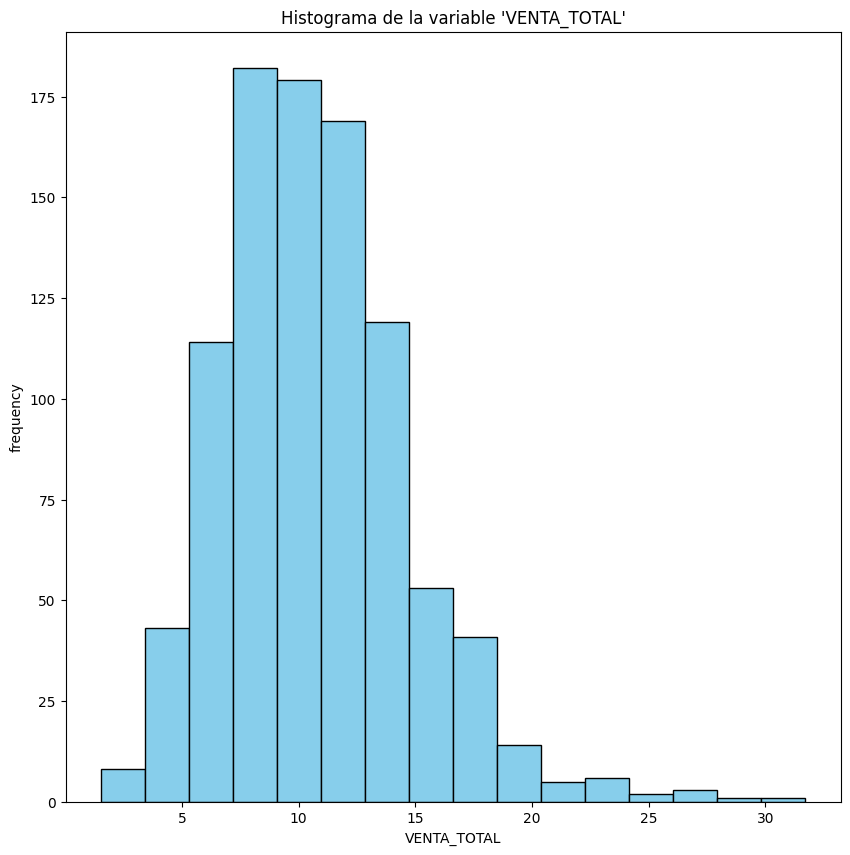

In [605]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['VENTA_TOTAL'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'VENTA_TOTAL'")
plt.xlabel("VENTA_TOTAL")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

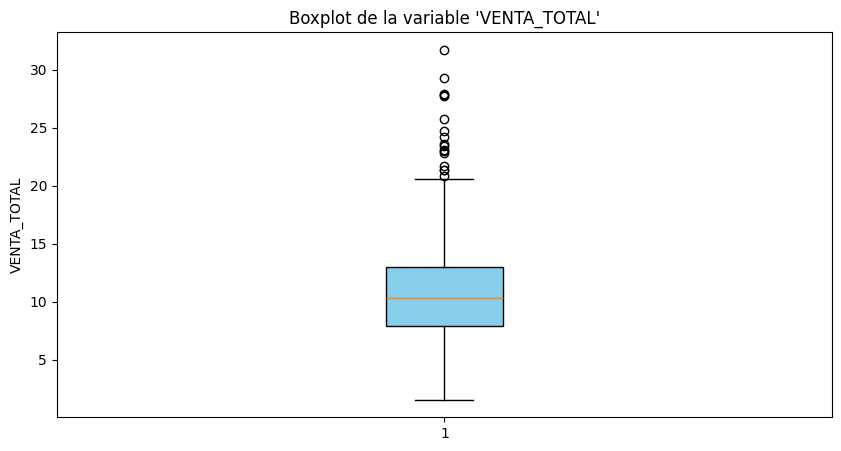

In [606]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['VENTA_TOTAL'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'VENTA_TOTAL'")
plt.ylabel("VENTA_TOTAL")
plt.show()

###Variable 'MTS2VENTAS_NUM'

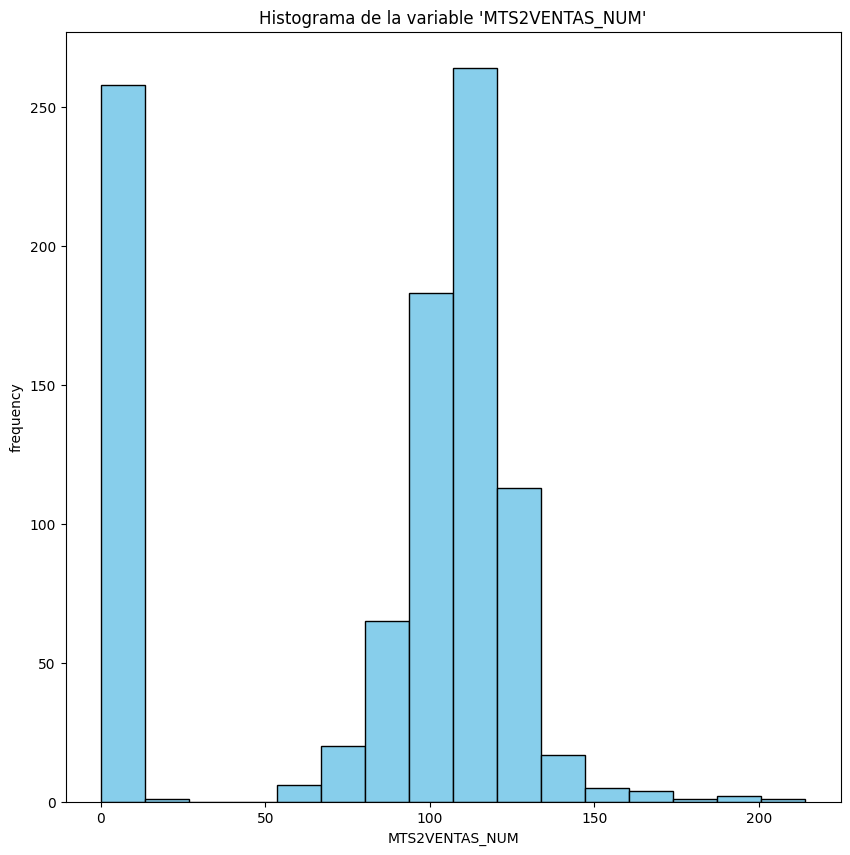

In [607]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['MTS2VENTAS_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'MTS2VENTAS_NUM'")
plt.xlabel("MTS2VENTAS_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

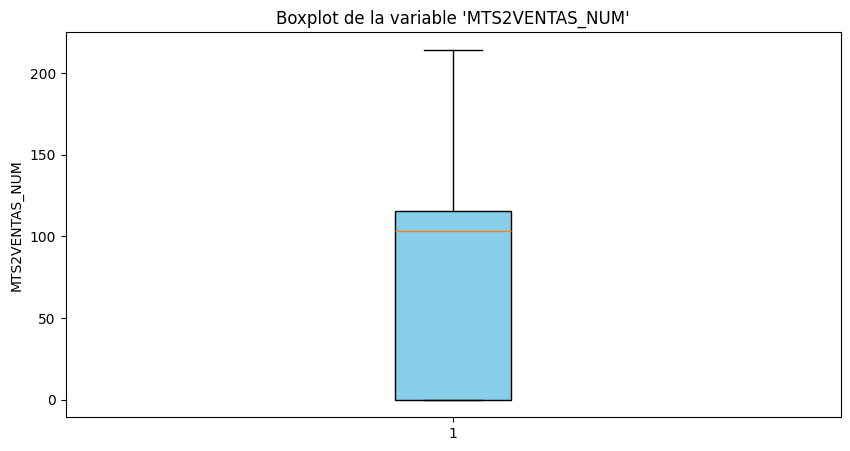

In [608]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['MTS2VENTAS_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'MTS2VENTAS_NUM'")
plt.ylabel("MTS2VENTAS_NUM")
plt.show()

###Variable 'PUERTASREFRIG_NUM'

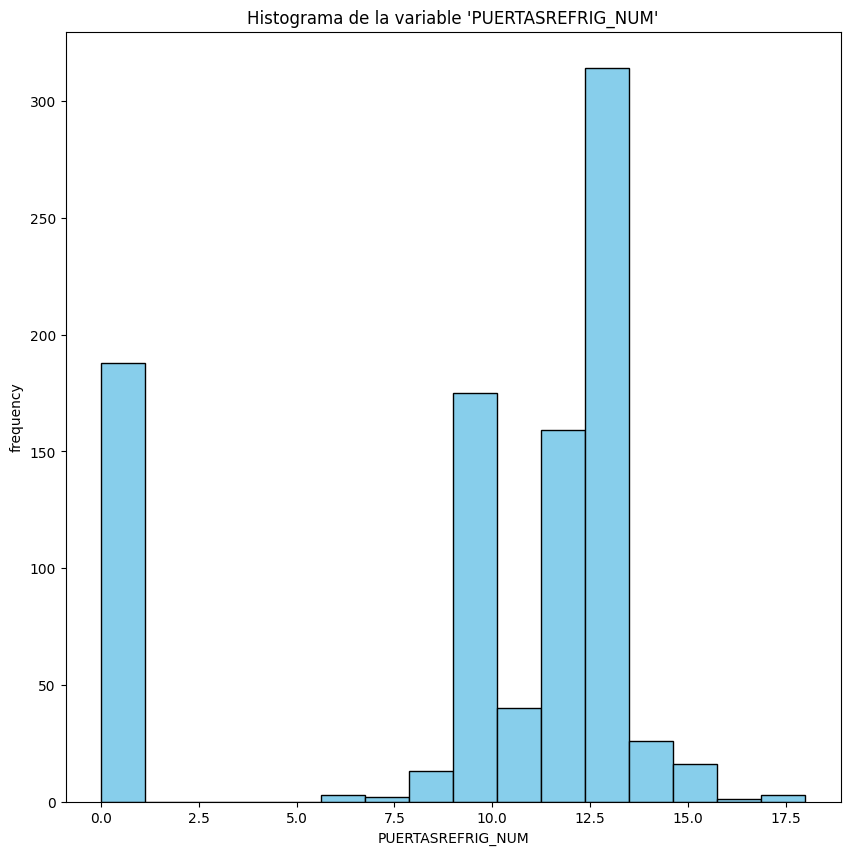

In [609]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['PUERTASREFRIG_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'PUERTASREFRIG_NUM'")
plt.xlabel("PUERTASREFRIG_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

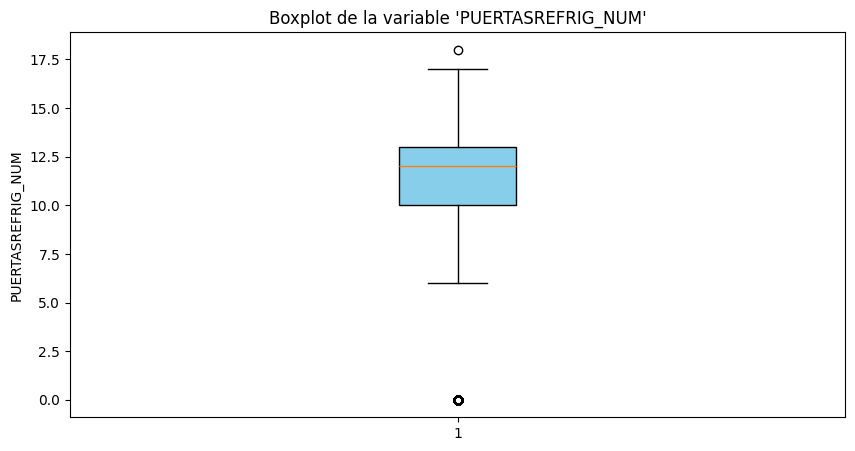

In [610]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['PUERTASREFRIG_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'PUERTASREFRIG_NUM'")
plt.ylabel("PUERTASREFRIG_NUM")
plt.show()

###Variable 'CAJONESESTACIONAMIENTO_NUM'

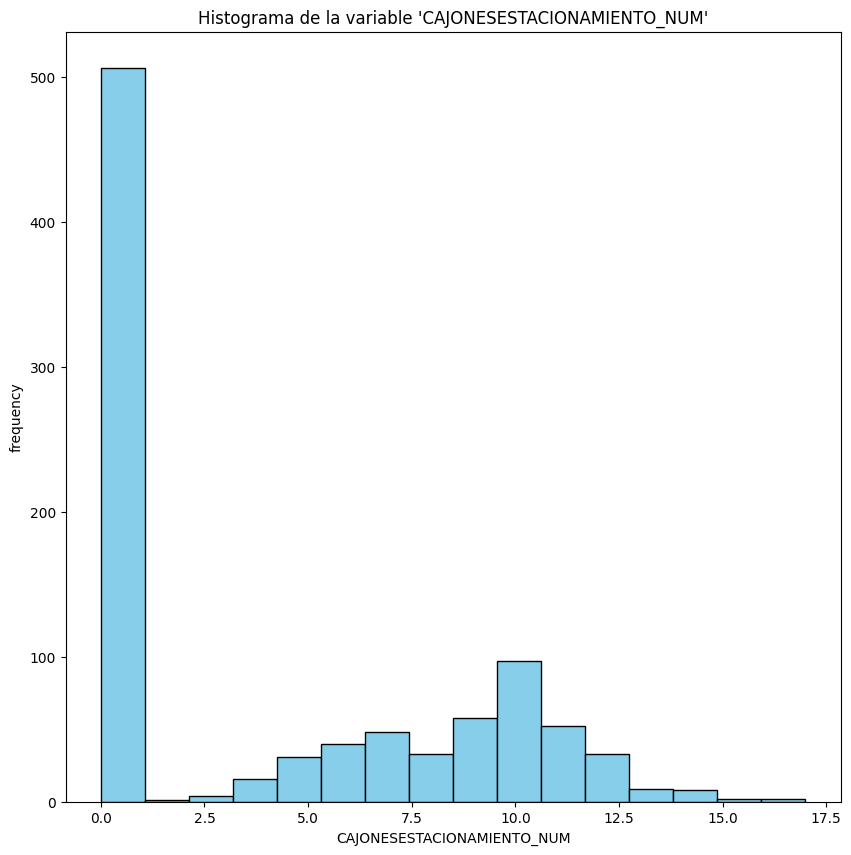

In [611]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['CAJONESESTACIONAMIENTO_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'CAJONESESTACIONAMIENTO_NUM'")
plt.xlabel("CAJONESESTACIONAMIENTO_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

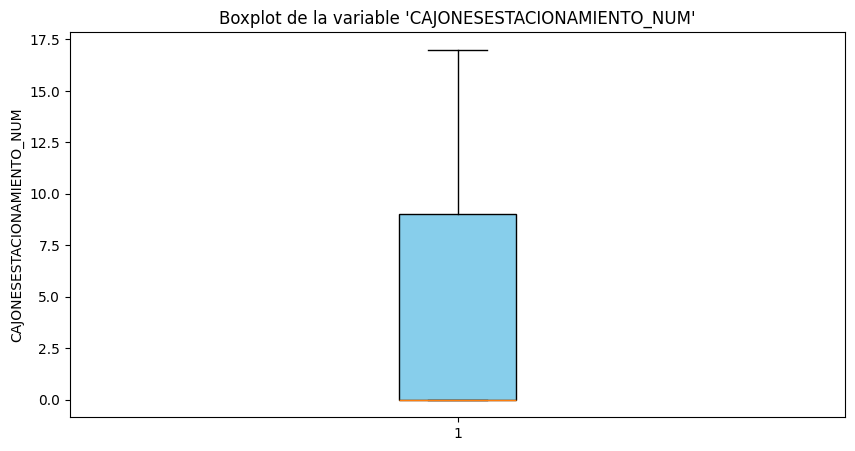

In [612]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['CAJONESESTACIONAMIENTO_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'CAJONESESTACIONAMIENTO_NUM'")
plt.ylabel("CAJONESESTACIONAMIENTO_NUM")
plt.show()

###Variable 'LATITUD_NUM'

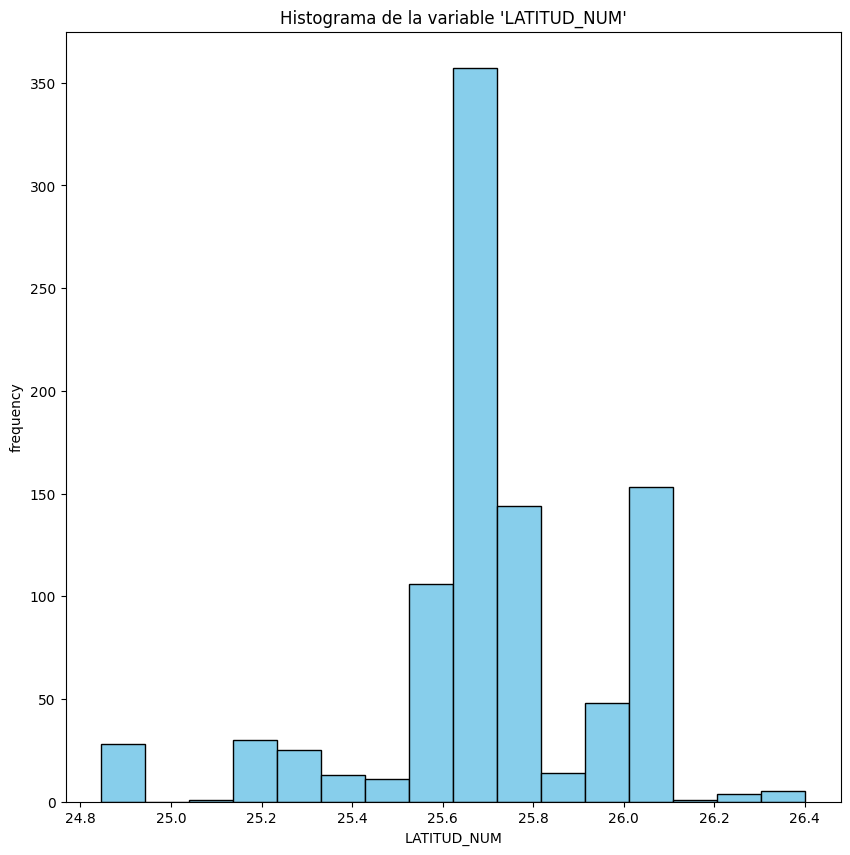

In [613]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['LATITUD_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'LATITUD_NUM'")
plt.xlabel("LATITUD_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

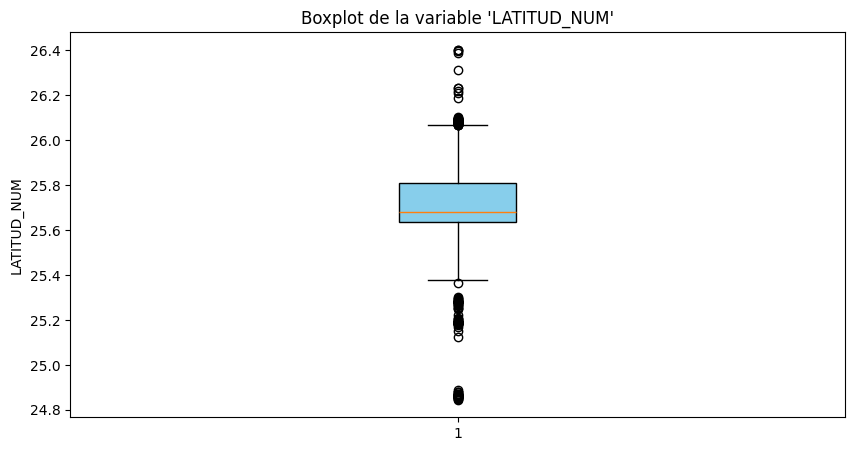

In [614]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['LATITUD_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'LATITUD_NUM'")
plt.ylabel("LATITUD_NUM")
plt.show()

###Variable 'LONGITUD_NUM'

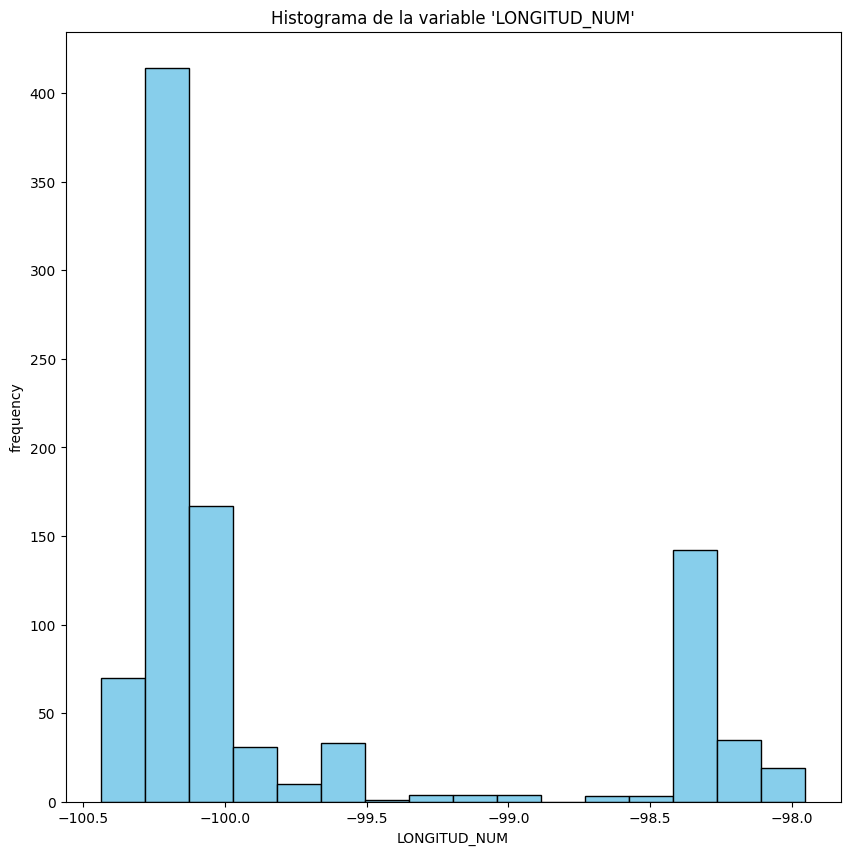

In [615]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['LONGITUD_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'LONGITUD_NUM'")
plt.xlabel("LONGITUD_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

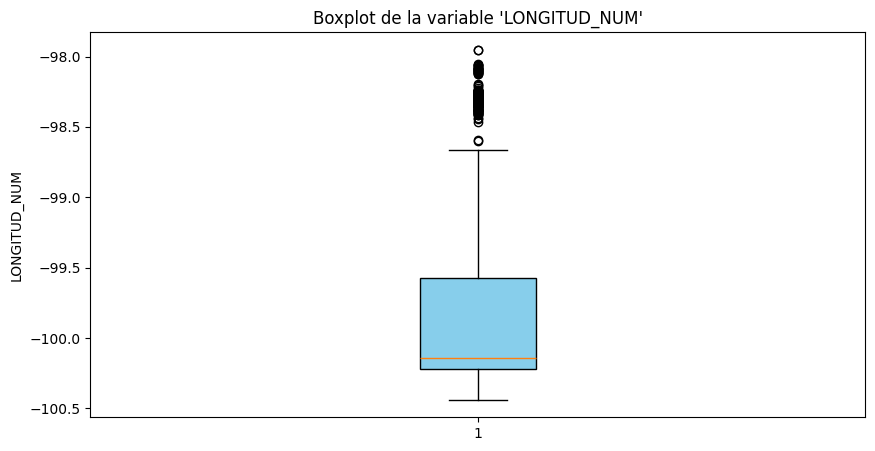

In [616]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['LONGITUD_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'LONGITUD_NUM'")
plt.ylabel("LONGITUD_NUM")
plt.show()

###Variable 'POBLACION'

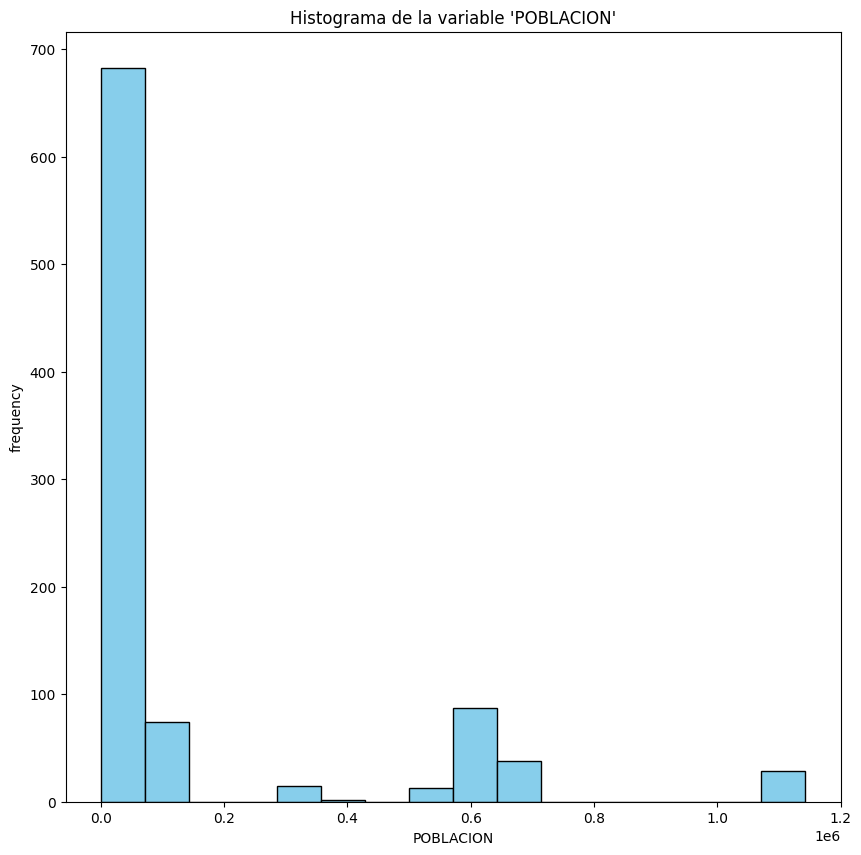

In [617]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['POBLACION'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'POBLACION'")
plt.xlabel("POBLACION")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

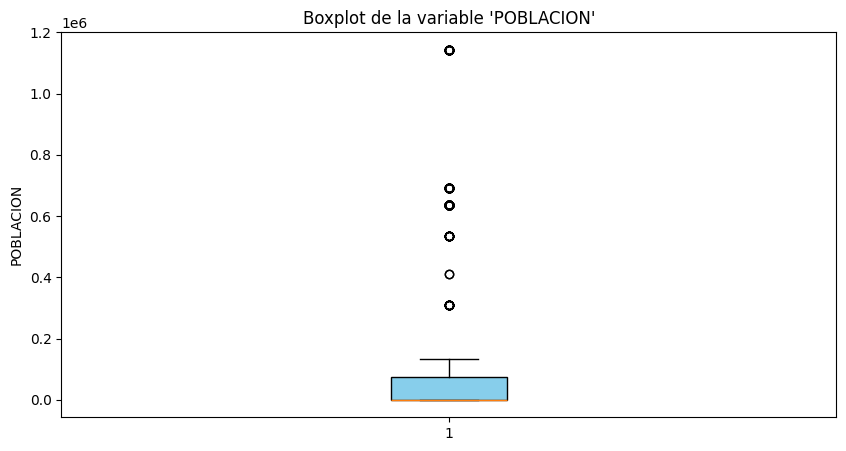

In [618]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['POBLACION'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'POBLACION'")
plt.ylabel("POBLACION")
plt.show()

###Variable 'COMPETIDORES_NUM'

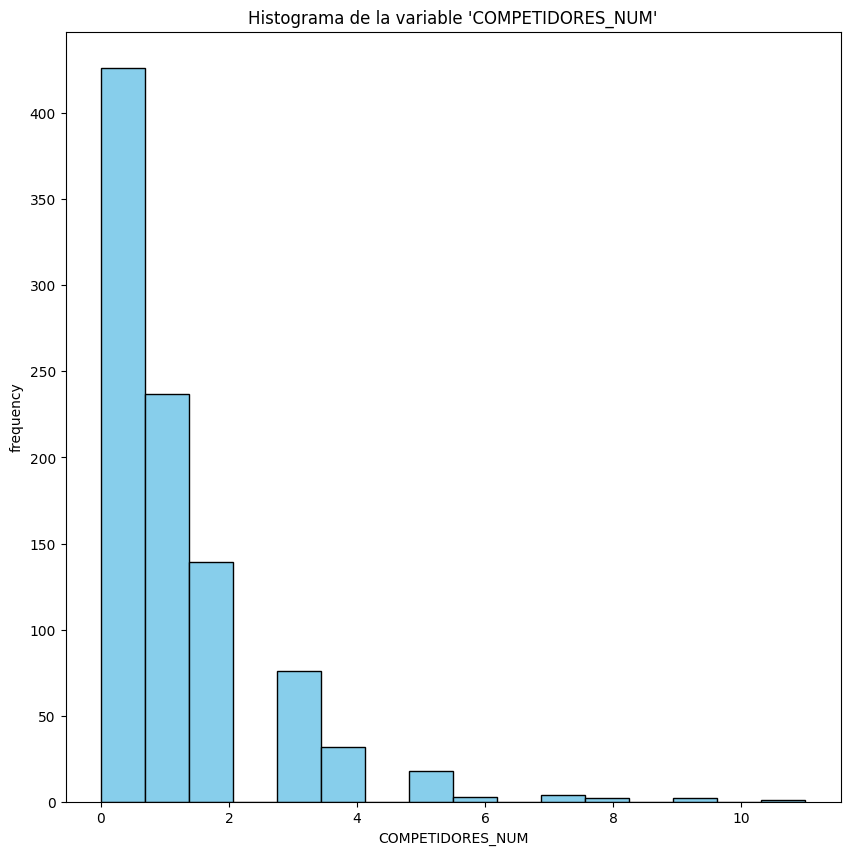

In [619]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['COMPETIDORES_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'COMPETIDORES_NUM'")
plt.xlabel("COMPETIDORES_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

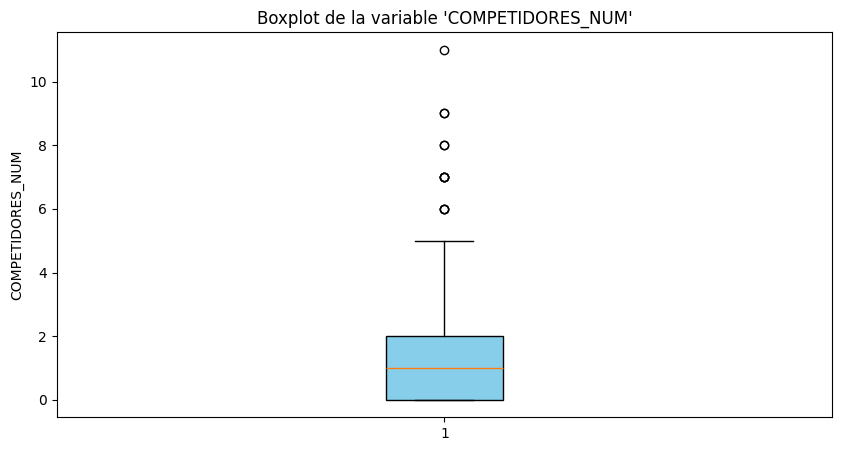

In [620]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['COMPETIDORES_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'COMPETIDORES_NUM'")
plt.ylabel("COMPETIDORES_NUM")
plt.show()

###Variable 'ESCUELAS_NUM'

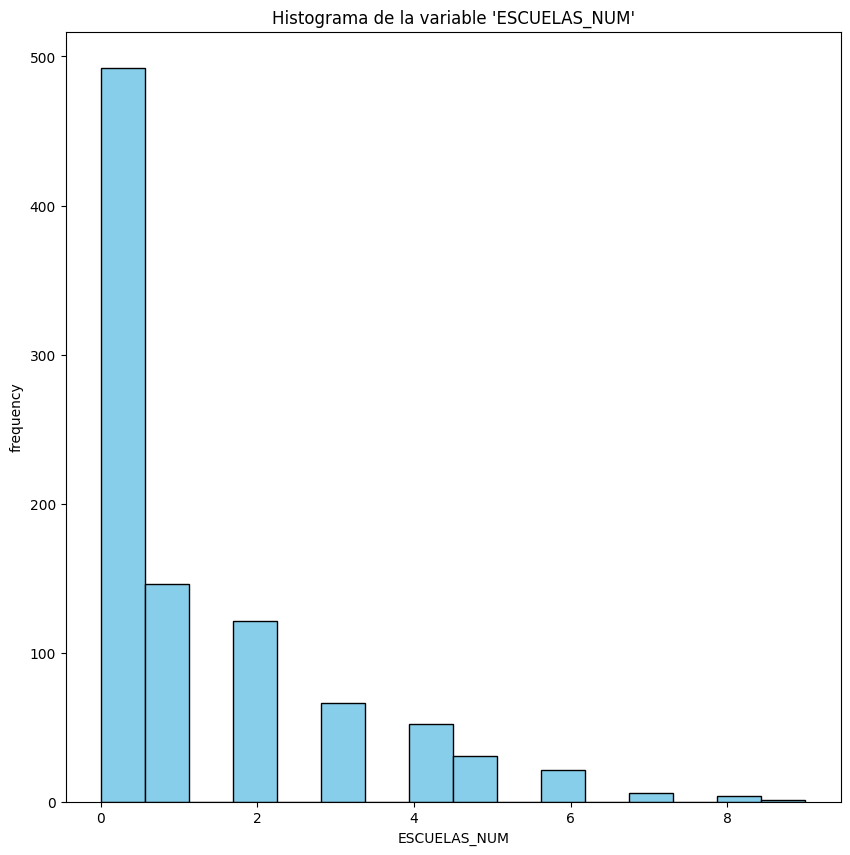

In [621]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['ESCUELAS_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'ESCUELAS_NUM'")
plt.xlabel("ESCUELAS_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

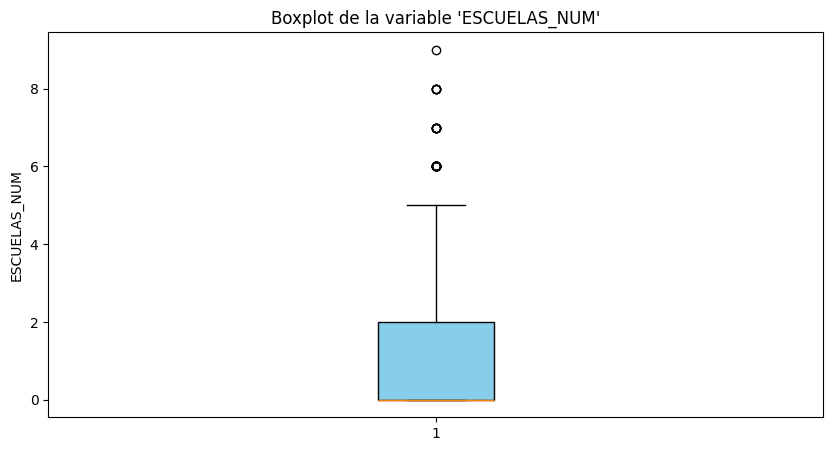

In [622]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['ESCUELAS_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'ESCUELAS_NUM'")
plt.ylabel("ESCUELAS_NUM")
plt.show()

###Variable 'HOSPITALES_NUM'

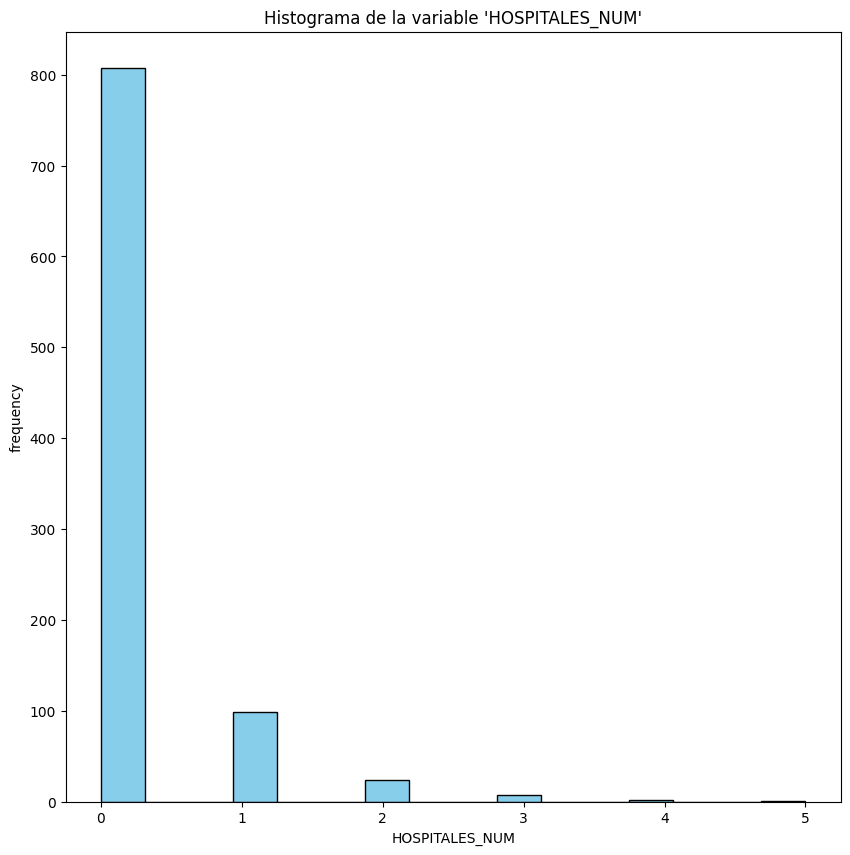

In [623]:
# Crear el histograma
plt.figure(figsize=(10, 10))
plt.hist(df_tienda_limpia['HOSPITALES_NUM'],bins=16, edgecolor='black', color='skyblue')

# Añadir título y etiquetas al histograma
plt.title("Histograma de la variable 'HOSPITALES_NUM'")
plt.xlabel("HOSPITALES_NUM")
plt.ylabel("frequency")

# Mostrar el histograma
plt.show()

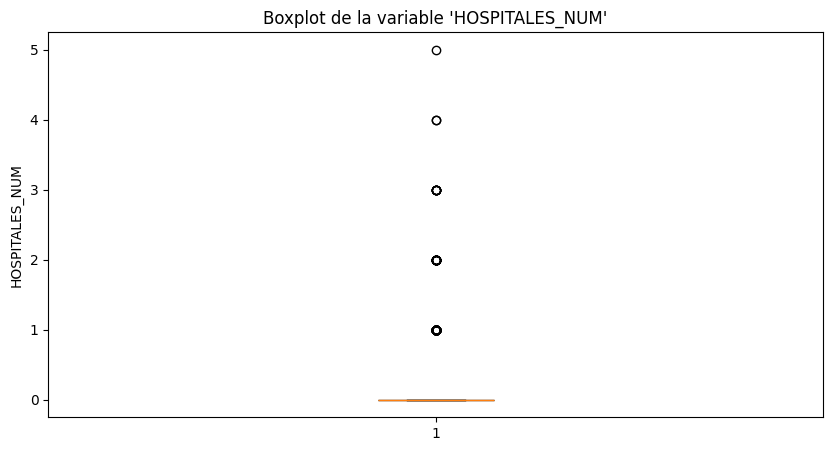

In [624]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_tienda_limpia['HOSPITALES_NUM'].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))  # importante quitar NaNs si los hay
plt.title("Boxplot de la variable 'HOSPITALES_NUM'")
plt.ylabel("HOSPITALES_NUM")
plt.show()

##Variables categóricas

###Variable 'Above_Goal'

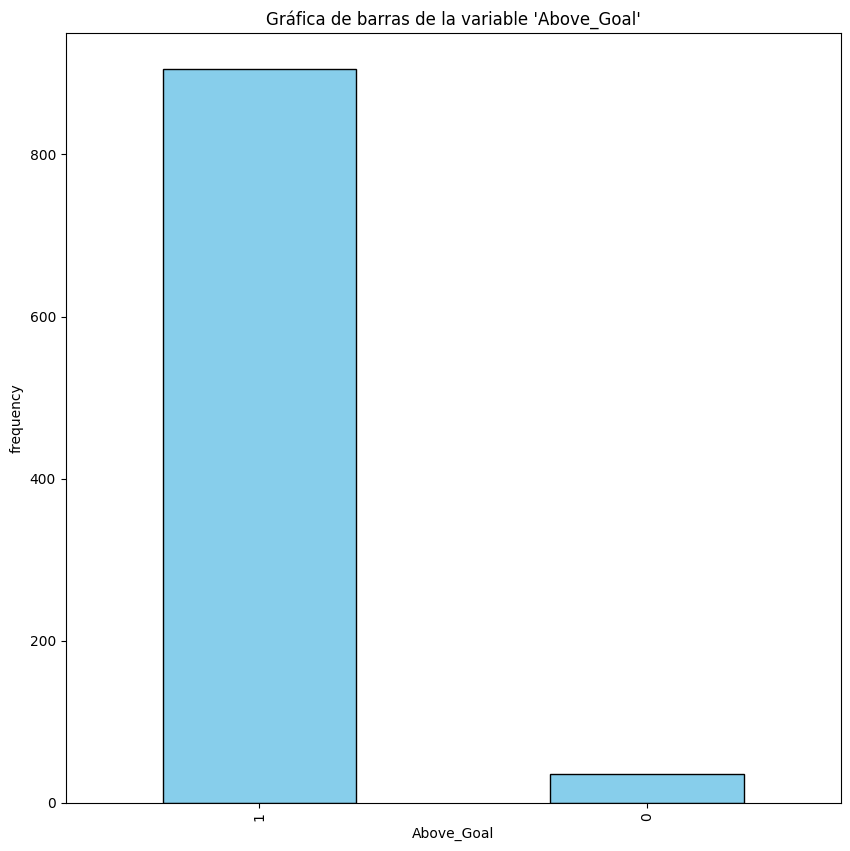

In [625]:
conteo = df_tienda_limpia['Above_Goal'].value_counts()
# Crear la gráfica de barras
plt.figure(figsize=(10, 10))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title("Gráfica de barras de la variable 'Above_Goal'")
plt.xlabel("Above_Goal")
plt.ylabel("frequency")

# Mostrar la gráfica de barras
plt.show()

###Variables de ubicación

In [626]:
ubicacion = [len(df_tienda_limpia[df_tienda_limpia['LONGITUD_NUM'] < -99.313] == True), len(df_tienda_limpia[df_tienda_limpia['LONGITUD_NUM'] >= -99.313 ] == True)]
ubicacion

[726, 214]

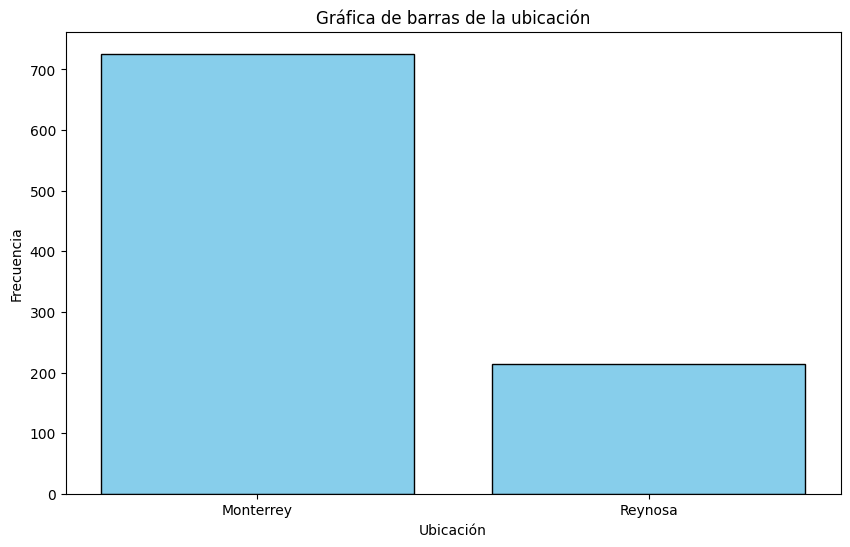

In [627]:
# Etiquetas para las barras
nombres = ['Monterrey', 'Reynosa']

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(nombres, ubicacion, color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title("Gráfica de barras de la ubicación")
plt.xlabel("Ubicación")
plt.ylabel("Frecuencia")

# Mostrar la gráfica
plt.show()

###Variable 'PLAZA_CVE'

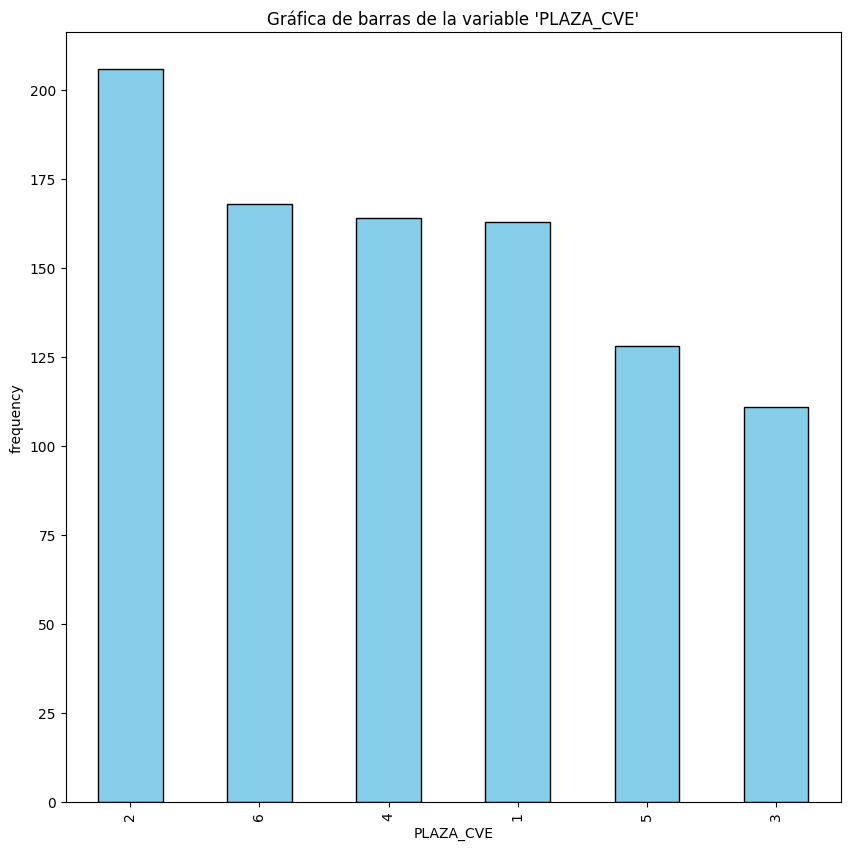

In [628]:
conteo = df_tienda_limpia['PLAZA_CVE'].value_counts()
# Crear la gráfica de barras
plt.figure(figsize=(10, 10))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title("Gráfica de barras de la variable 'PLAZA_CVE'")
plt.xlabel("PLAZA_CVE")
plt.ylabel("frequency")

# Mostrar la gráfica de barras
plt.show()

###Variable 'NIVELSOCIOECONOMICO_DES'

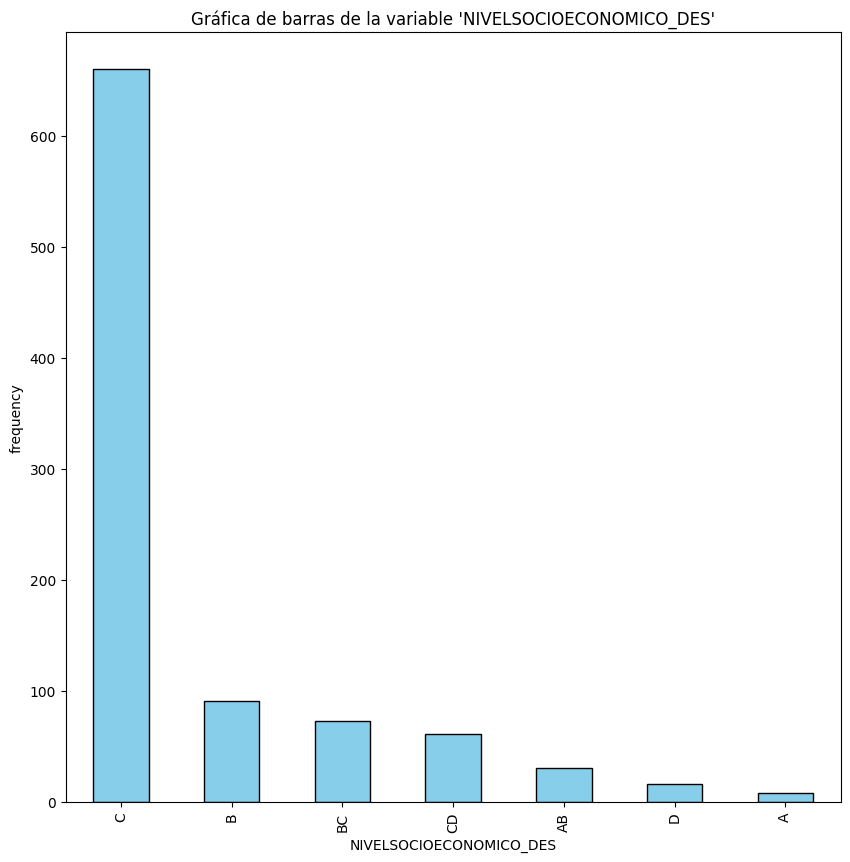

In [629]:
conteo = df_tienda_limpia['NIVELSOCIOECONOMICO_DES'].value_counts()
# Crear la gráfica de barras
plt.figure(figsize=(10, 10))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title("Gráfica de barras de la variable 'NIVELSOCIOECONOMICO_DES'")
plt.xlabel("NIVELSOCIOECONOMICO_DES")
plt.ylabel("frequency")

# Mostrar la gráfica de barras
plt.show()

###Variable 'ENTORNO_DES'

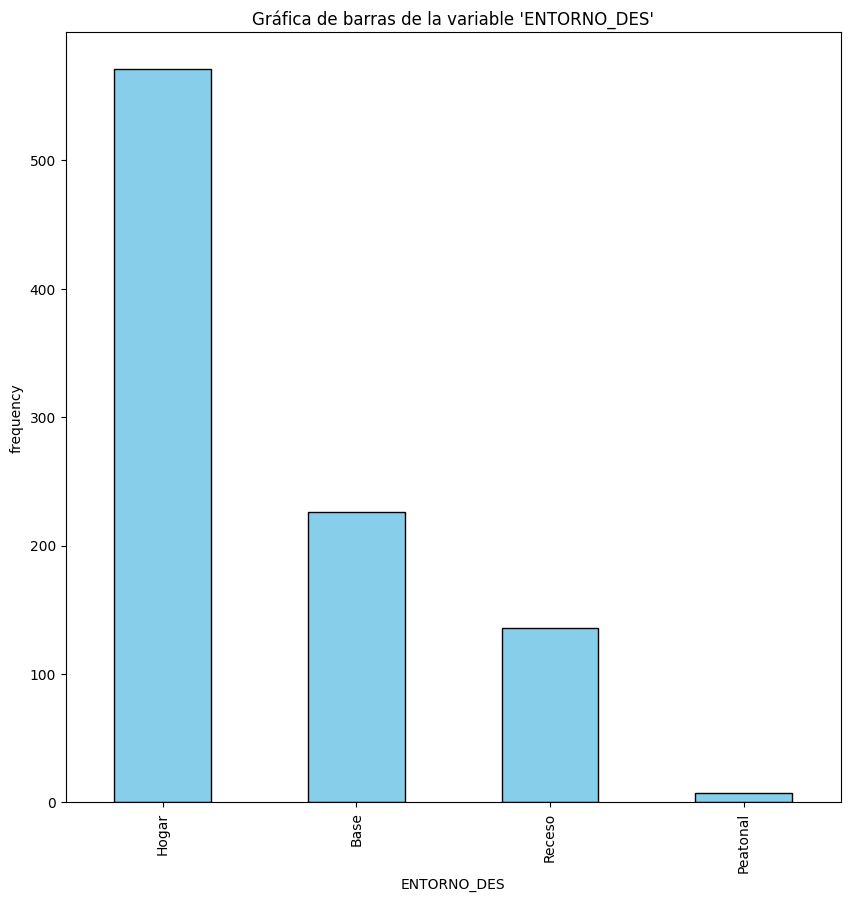

In [630]:
conteo = df_tienda_limpia['ENTORNO_DES'].value_counts()
# Crear la gráfica de barras
plt.figure(figsize=(10, 10))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title("Gráfica de barras de la variable 'ENTORNO_DES'")
plt.xlabel("ENTORNO_DES")
plt.ylabel("frequency")

# Mostrar la gráfica de barras
plt.show()

###Variable 'SEGMENTO_MAESTRO_DESC'

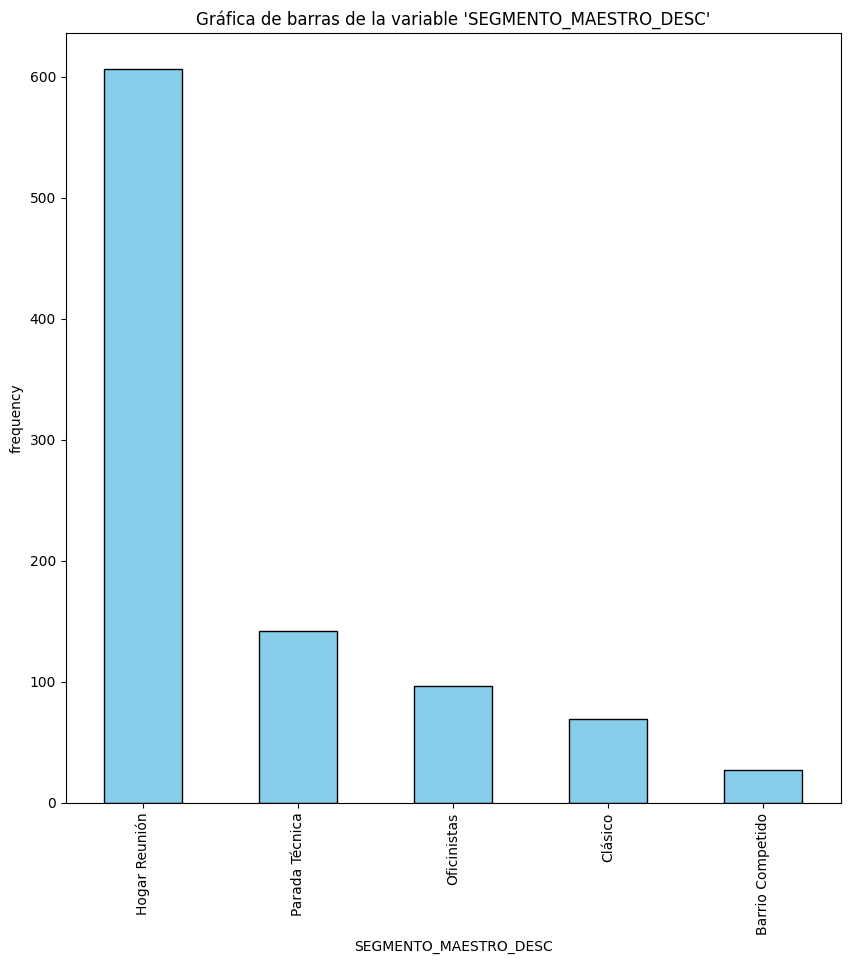

In [631]:
conteo = df_tienda_limpia['SEGMENTO_MAESTRO_DESC'].value_counts()
# Crear la gráfica de barras
plt.figure(figsize=(10, 10))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title("Gráfica de barras de la variable 'SEGMENTO_MAESTRO_DESC'")
plt.xlabel("SEGMENTO_MAESTRO_DESC")
plt.ylabel("frequency")

# Mostrar la gráfica de barras
plt.show()

###Variable 'LID_UBICACION_TIENDA'

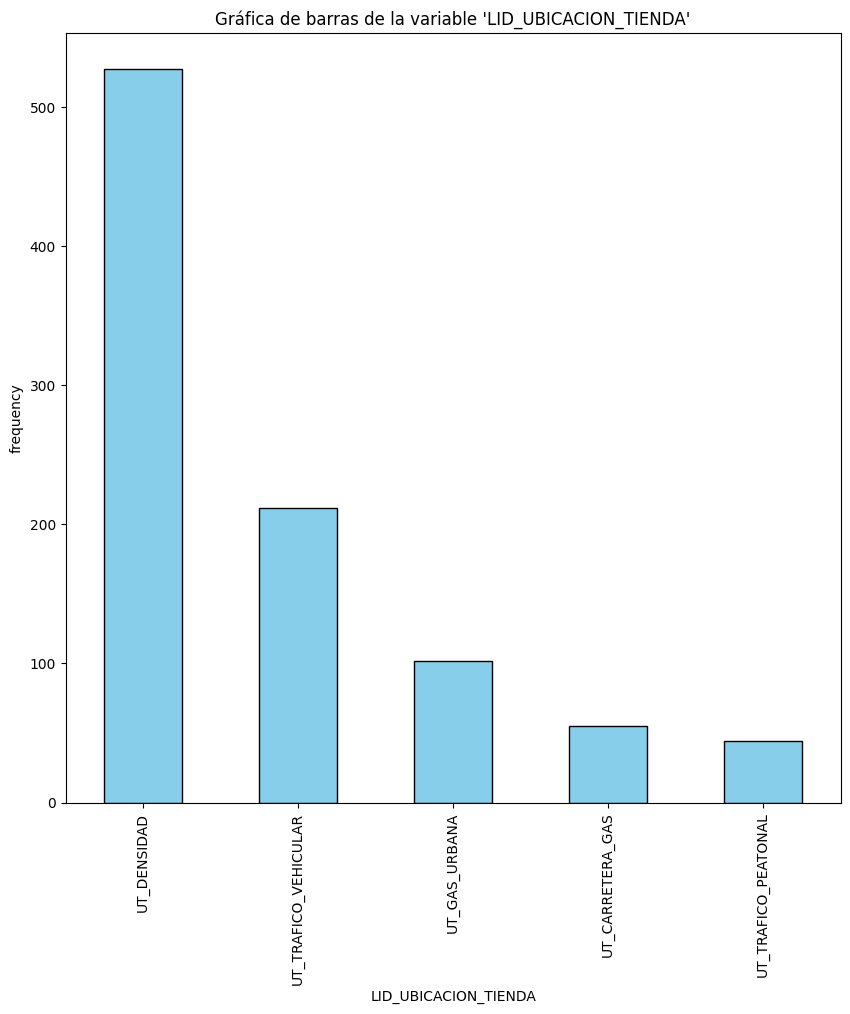

In [632]:
conteo = df_tienda_limpia['LID_UBICACION_TIENDA'].value_counts()
# Crear la gráfica de barras
plt.figure(figsize=(10, 10))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title("Gráfica de barras de la variable 'LID_UBICACION_TIENDA'")
plt.xlabel("LID_UBICACION_TIENDA")
plt.ylabel("frequency")

# Mostrar la gráfica de barras
plt.show()

#Correlaciones

##Variables numéricas

In [633]:
# Filtrar solo columnas numéricas y eliminar filas con NaN
df_num = df_tienda_limpia.select_dtypes(include=['number']).dropna()

# Calcular matriz de correlación
matriz_correlacion = df_num.corr()

# Mostrar matriz de correlación
matriz_correlacion

,TIENDA_ID,VENTA_TOTAL,PLAZA_CVE,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,Meta_venta,Above_Goal,Percentage_of_Goal,POBLACION,COMPETIDORES_NUM,ESCUELAS_NUM,HOSPITALES_NUM
TIENDA_ID,1.000000,-0.157251,-0.287880,-0.071806,-0.326604,0.088981,0.532937,0.565609,-0.023137,-0.105141,-0.158049,-0.064120,-0.205238,-0.097569,-0.094403
VENTA_TOTAL,-0.157251,1.000000,-0.060377,0.199838,0.205732,0.166681,-0.024499,0.038195,0.098239,0.338360,0.997161,0.085239,0.042433,-0.093242,0.058281
PLAZA_CVE,-0.287880,-0.060377,1.000000,-0.199094,-0.026282,-0.265082,-0.564760,-0.304359,0.021010,-0.046218,-0.063127,-0.306369,-0.091205,-0.140629,0.008367
MTS2VENTAS_NUM,-0.071806,0.199838,-0.199094,1.000000,0.535662,0.541114,0.149017,-0.011958,0.131688,0.128783,0.192859,0.059970,0.161924,0.136821,0.059951
PUERTASREFRIG_NUM,-0.326604,0.205732,-0.026282,0.535662,1.000000,0.262238,-0.125200,-0.317550,0.039531,0.131282,0.204218,0.087045,0.183708,0.194160,0.017882
CAJONESESTACIONAMIENTO_NUM,0.088981,0.166681,-0.265082,0.541114,0.262238,1.000000,0.343037,0.322342,0.035075,0.144517,0.166319,0.020141,0.014469,-0.009060,-0.029592
LATITUD_NUM,0.532937,-0.024499,-0.564760,0.149017,-0.125200,0.343037,1.000000,0.576949,-0.003759,0.021669,-0.022926,0.069980,-0.090446,-0.067175,-0.171158
LONGITUD_NUM,0.565609,0.038195,-0.304359,-0.011958,-0.317550,0.322342,0.576949,1.000000,0.120528,0.045035,0.029857,-0.087654,-0.254063,-0.319886,-0.043677
Meta_venta,-0.023137,0.098239,0.021010,0.131688,0.039531,0.035075,-0.003759,0.120528,1.000000,0.013097,0.028184,0.002496,-0.008043,-0.078095,0.051630
Above_Goal,-0.105141,0.338360,-0.046218,0.128783,0.131282,0.144517,0.021669,0.045035,0.013097,1.000000,0.340056,0.069401,0.023908,-0.019182,0.028194


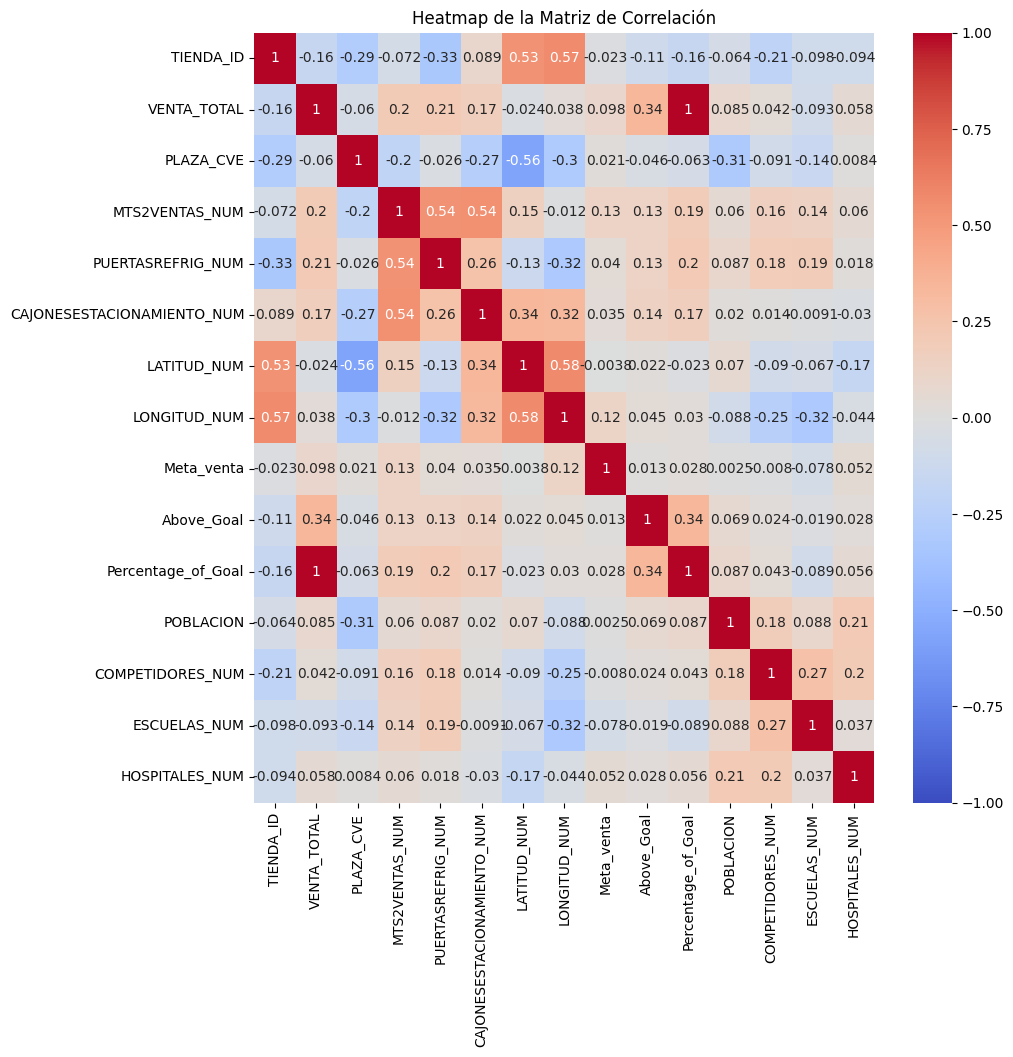

In [634]:
# Crear el heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Añadir título
plt.title("Heatmap de la Matriz de Correlación")

# Mostrar el heatmap
plt.show()

#Transformación

##Importar datos

In [635]:
#Importar los dataframes train_df y test_df
train_df = pd.read_csv('df_tienda_limpia.csv', header=0)
test_df = pd.read_csv('df_tienda_limpia_test.csv', header=0)

##Codificar datos categóricos

In [636]:
mapa_niveles = {
    'A': 4.0,
    'AB': 3.5,
    'B': 3.0,
    'BC': 2.5,
    'C': 2.0,
    'CD': 1.5,
    'D': 1.0
}

train_df['NIVELSOCIOECONOMICO_DES'] = train_df['NIVELSOCIOECONOMICO_DES'].map(mapa_niveles)
test_df['NIVELSOCIOECONOMICO_DES'] = test_df['NIVELSOCIOECONOMICO_DES'].map(mapa_niveles)

In [637]:
# prompt: create dummy variables for NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA for train and test

# List of categorical columns to one-hot encode
categorical_cols = ['ENTORNO_DES', 'SEGMENTO_MAESTRO_DESC', 'LID_UBICACION_TIENDA']

# Create dummy variables for the train dataset
train_dummies = pd.get_dummies(train_df[categorical_cols], prefix=categorical_cols, dummy_na=False)

# Concatenate the new dummy columns with the original train dataset and drop the original columns
train_df = pd.concat([train_df, train_dummies], axis=1)
train_df = train_df.drop(columns=categorical_cols)

# Create dummy variables for the test dataset
test_dummies = pd.get_dummies(test_df[categorical_cols], prefix=categorical_cols, dummy_na=False)

# Concatenate the new dummy columns with the original test dataset and drop the original columns
test_df = pd.concat([test_df, test_dummies], axis=1)
test_df = test_df.drop(columns=categorical_cols)

# Align the columns of the test set with the training set, filling missing columns with 0
train_cols = train_df.columns
test_cols = test_df.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    test_df[c] = 0
# Ensure the order of columns is the same
test_df = test_df[train_cols]

# Display the first few rows of the transformed dataframes
print("Train DataFrame after one-hot encoding:")
print(train_df.head())
print("\nTest DataFrame after one-hot encoding:")
print(test_df.head())


Train DataFrame after one-hot encoding:
   TIENDA_ID  VENTA_TOTAL  PLAZA_CVE  NIVELSOCIOECONOMICO_DES  MTS2VENTAS_NUM  \
0        126     9.827529          1                      2.5          127.42   
1        681     9.019971          1                      2.0          128.13   
2        117     4.945149          1                      2.0           87.62   
3        682     9.685383          1                      2.0           90.70   
4        275     8.594114          1                      2.0           95.30   

   PUERTASREFRIG_NUM  CAJONESESTACIONAMIENTO_NUM  LATITUD_NUM  LONGITUD_NUM  \
0                 13                           7     25.69107    -100.21261   
1                 13                           0     25.73571    -100.18086   
2                 11                          11     25.71883    -100.19133   
3                 13                           0     25.66952    -100.20744   
4                 13                           6     25.73766    -100.16116   

##Imputar datos de MTS2

In [638]:
from math import radians, cos, sin, asin, sqrt

# === Fórmula de Haversine para calcular distancia en km ===
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# === Datos válidos y datos con 0 ===
df_valid = train_df[train_df['MTS2VENTAS_NUM'] > 0].copy()
df_zero = train_df[train_df['MTS2VENTAS_NUM'] == 0].copy()

media_global = df_valid['MTS2VENTAS_NUM'].mean()

# === Imputación por proximidad geográfica ===
imputed_values = []
for idx, row in df_zero.iterrows():
    lat0, lon0 = row['LATITUD_NUM'], row['LONGITUD_NUM']
    df_valid['dist_km'] = df_valid.apply(
        lambda r: haversine(lat0, lon0, r['LATITUD_NUM'], r['LONGITUD_NUM']), axis=1)

    vecinos = df_valid[df_valid['dist_km'] <= 1]

    if not vecinos.empty:
        imputed_value = vecinos['MTS2VENTAS_NUM'].mean()
    else:
        imputed_value = media_global

    imputed_values.append(imputed_value)

# Asignar valores imputados
df_zero['MTS2VENTAS_NUM'] = imputed_values

# Reunir el DataFrame final
df_imputado = pd.concat([df_valid.drop(columns='dist_km'), df_zero], ignore_index=True)

# Opcional: ordenar si lo necesitas
# df_imputado.sort_values(by='ID_original', inplace=True)


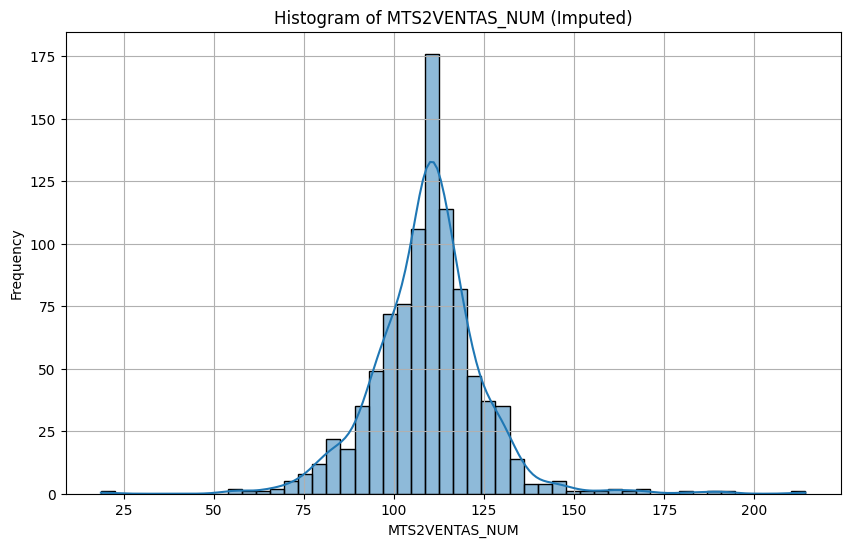

In [639]:
# prompt: histogram df_imputado[MTS2VENTAS_NUM]

plt.figure(figsize=(10, 6))
sns.histplot(df_imputado['MTS2VENTAS_NUM'], bins=50, kde=True)
plt.title('Histogram of MTS2VENTAS_NUM (Imputed)')
plt.xlabel('MTS2VENTAS_NUM')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

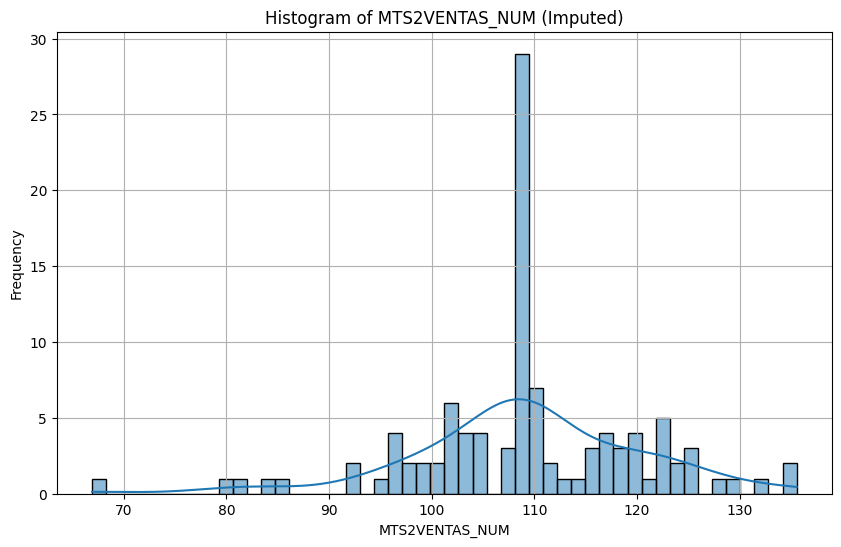

In [640]:


# === Datos válidos y datos con 0 ===
df_valid = test_df[test_df['MTS2VENTAS_NUM'] > 0].copy()
df_zero = test_df[test_df['MTS2VENTAS_NUM'] == 0].copy()

media_global = df_valid['MTS2VENTAS_NUM'].mean()

# === Imputación por proximidad geográfica ===
imputed_values = []
for idx, row in df_zero.iterrows():
    lat0, lon0 = row['LATITUD_NUM'], row['LONGITUD_NUM']
    df_valid['dist_km'] = df_valid.apply(
        lambda r: haversine(lat0, lon0, r['LATITUD_NUM'], r['LONGITUD_NUM']), axis=1)

    vecinos = df_valid[df_valid['dist_km'] <= 1]

    if not vecinos.empty:
        imputed_value = vecinos['MTS2VENTAS_NUM'].mean()
    else:
        imputed_value = media_global

    imputed_values.append(imputed_value)

# Asignar valores imputados
df_zero['MTS2VENTAS_NUM'] = imputed_values

# Reunir el DataFrame final
df_imputado_test = pd.concat([df_valid.drop(columns='dist_km'), df_zero], ignore_index=True)

# prompt: histogram df_imputado[MTS2VENTAS_NUM]

plt.figure(figsize=(10, 6))
sns.histplot(df_imputado_test['MTS2VENTAS_NUM'], bins=50, kde=True)
plt.title('Histogram of MTS2VENTAS_NUM (Imputed)')
plt.xlabel('MTS2VENTAS_NUM')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#Guardar datasets imputados

In [641]:
# prompt: save and download df_imputado and df_imputado_test

df_imputado.to_csv('df_imputado.csv', index=False)

df_imputado_test.to_csv('df_imputado_test.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Aplicar modelos

###Modelo de regresión

In [333]:
df_imputado.columns

Index(['TIENDA_ID', 'VENTA_TOTAL', 'PLAZA_CVE', 'NIVELSOCIOECONOMICO_DES',
       'MTS2VENTAS_NUM', 'PUERTASREFRIG_NUM', 'CAJONESESTACIONAMIENTO_NUM',
       'LATITUD_NUM', 'LONGITUD_NUM', 'Meta_venta', 'Above_Goal',
       'Percentage_of_Goal', 'POBLACION', 'COMPETIDORES_NUM', 'ESCUELAS_NUM',
       'HOSPITALES_NUM', 'ENTORNO_DES_Base', 'ENTORNO_DES_Hogar',
       'ENTORNO_DES_Peatonal', 'ENTORNO_DES_Receso',
       'SEGMENTO_MAESTRO_DESC_Barrio Competido',
       'SEGMENTO_MAESTRO_DESC_Clásico', 'SEGMENTO_MAESTRO_DESC_Hogar Reunión',
       'SEGMENTO_MAESTRO_DESC_Oficinistas',
       'SEGMENTO_MAESTRO_DESC_Parada Técnica',
       'LID_UBICACION_TIENDA_UT_CARRETERA_GAS',
       'LID_UBICACION_TIENDA_UT_DENSIDAD',
       'LID_UBICACION_TIENDA_UT_GAS_URBANA',
       'LID_UBICACION_TIENDA_UT_TRAFICO_PEATONAL',
       'LID_UBICACION_TIENDA_UT_TRAFICO_VEHICULAR'],
      dtype='object')

In [481]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features (input variables) and target (output variable)
features = ['PLAZA_CVE', 'NIVELSOCIOECONOMICO_DES',
       'MTS2VENTAS_NUM', 'PUERTASREFRIG_NUM', 'CAJONESESTACIONAMIENTO_NUM',
       'LATITUD_NUM', 'LONGITUD_NUM', 'POBLACION', 'COMPETIDORES_NUM', 'ESCUELAS_NUM',
       'HOSPITALES_NUM', 'ENTORNO_DES_Base', 'ENTORNO_DES_Hogar',
       'ENTORNO_DES_Peatonal', 'ENTORNO_DES_Receso',
       'SEGMENTO_MAESTRO_DESC_Barrio Competido',
       'SEGMENTO_MAESTRO_DESC_Clásico', 'SEGMENTO_MAESTRO_DESC_Hogar Reunión',
       'SEGMENTO_MAESTRO_DESC_Oficinistas',
       'SEGMENTO_MAESTRO_DESC_Parada Técnica',
       'LID_UBICACION_TIENDA_UT_CARRETERA_GAS',
       'LID_UBICACION_TIENDA_UT_DENSIDAD',
       'LID_UBICACION_TIENDA_UT_GAS_URBANA',
       'LID_UBICACION_TIENDA_UT_TRAFICO_PEATONAL',
       'LID_UBICACION_TIENDA_UT_TRAFICO_VEHICULAR']
target = ['VENTA_TOTAL','Above_Goal']

# Separate features and target fo8r training and testing sets
X_train = df_imputado[features]
y_train = df_imputado[target]
X_test = df_imputado_test[features]
y_test = df_imputado_test[target]

In [178]:
#Inicializar el moderlo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#Obtener importancias
importances = rf.feature_importances_

#Crear un dataframe con las importancias
df_importancias = pd.DataFrame({
    'variable': X_train.columns,
    'importancia': importances
})

# Ordenando las características por su importancia
feature_importances = df_importancias.sort_values(by='importancia', ascending=False)

# Mostrando las características más importantes
feature_importances.head(15)

,variable,importancia
6,LONGITUD_NUM,0.253424
5,LATITUD_NUM,0.160508
2,MTS2VENTAS_NUM,0.130111
3,PUERTASREFRIG_NUM,0.093960
4,CAJONESESTACIONAMIENTO_NUM,0.060273
7,POBLACION,0.054534
8,COMPETIDORES_NUM,0.043610
1,NIVELSOCIOECONOMICO_DES,0.041124
9,ESCUELAS_NUM,0.035423
20,LID_UBICACION_TIENDA_UT_CARRETERA_GAS,0.015620


####Random Forest solito

In [179]:
# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust n_estimators and other parameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 7.152437676558865
R-squared (R2): 0.10651241043079329


####GridSearchCV con Random forest

In [181]:
param_grid = {
    'n_estimators': [100, 200, 300],              # Nº de árboles
    'max_depth': [None, 4, 7],                    # Profundidad máxima del árbol
    'min_samples_split': [10, 15, 18],              # Nº mínimo de muestras para dividir un nodo
    'min_samples_leaf': [2, 3],                # Nº mínimo de muestras en una hoja
    'max_features': [None, 'sqrt', 'log2'],     # Nº de features a considerar por división
    'bootstrap': [True, False]                    # Si se usan muestras con reemplazo
}

In [182]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo base
rf = RandomForestRegressor(random_state=42)

# GridSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    n_iter=40,
    param_distributions=param_grid,
    cv=5,                             # 5-fold cross-validation
    scoring='r2', # métrica
    n_jobs=-1,                        # usar todos los núcleos
    verbose=2                         # para ver el progreso
)

# Ajustar
random_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros:", random_search.best_params_)
print("Mejor r2:", random_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Mejor r2: 0.04980536817765757


In [184]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 6.986608607138433
R-squared (R2): 0.11627676009954829


###Modelo clasificador

####Random forest hiperparámetros

In [397]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 4, 7, 10, 3],                    # Profundidad máxima del árbol
    'criterion': ['gini','entropy'],
    'min_samples_split': [10, 15, 18, 8, 20],            # Nº mínimo de muestras para dividir un nodo
    'bootstrap': [True, False],                   # Si se usan muestras con reemplazo
    'class_weight': ['balanced', 'balanced_subsample']           # Peso de las clases
    }
y_train = df_imputado['Above_Goal']
y_test = df_imputado_test['Above_Goal']

In [ ]:
#guardados

#medio bueno 7
rf = RandomForestClassifier(random_state=42,
                            min_samples_leaf=3,
                            max_features='sqrt',
                            n_estimators=200,
                            max_depth=7,
                            criterion='gini',
                            bootstrap=True,
                            class_weight='balanced_subsample'
                            )


#medio mejor bueno 7.5
rf = RandomForestClassifier(random_state=42,
                            min_samples_leaf=3,
                            max_features='sqrt',
                            n_estimators=200,
                            max_depth=7,
                            criterion='gini',
                            bootstrap=False,
                            class_weight='balanced_subsample'
                            )

#buenillo 8
rf = RandomForestClassifier(random_state=42,
                            min_samples_leaf=3,
                            max_features='sqrt',
                            n_estimators=200,
                            max_depth=8,
                            criterion='gini',
                            bootstrap=False,
                            class_weight='balanced'
                            )

'''
precision    recall  f1-score   support

           0       0.29      1.00      0.45        35
           1       1.00      0.91      0.95       905

    accuracy                           0.91       940
   macro avg       0.65      0.95      0.70       940
weighted avg       0.97      0.91      0.93       940

Reporte Test
              precision    recall  f1-score   support

           0       0.20      0.50      0.29         4
           1       0.98      0.92      0.95       101

    accuracy                           0.90       105
   macro avg       0.59      0.71      0.62       105
weighted avg       0.95      0.90      0.92       105

[[ 2  2]
 [ 8 93]]
'''

#buenillo 8
rf = RandomForestClassifier(random_state=42,
                            min_samples_leaf=3,
                            max_features='sqrt',
                            n_estimators=200,
                            max_depth=8,
                            criterion='entropy',
                            bootstrap=True,
                            class_weight='balanced'
                            )

'''
              precision    recall  f1-score   support

           0       0.62      0.97      0.76        35
           1       1.00      0.98      0.99       905

    accuracy                           0.98       940
   macro avg       0.81      0.97      0.87       940
weighted avg       0.98      0.98      0.98       940

Reporte Test
              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.97      0.96      0.97       101

    accuracy                           0.93       105
   macro avg       0.58      0.61      0.59       105
weighted avg       0.94      0.93      0.94       105

[[ 1  3]
 [ 4 97]]
'''

#####Uno solito

In [420]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score

# Crear función de scoring que calcule recall para la clase 0
recall_class_0 = make_scorer(recall_score, pos_label=0)
precision_class_0 = make_scorer(precision_score, pos_label=0)
scoring = {
    'precision_class_0': make_scorer(precision_score, pos_label=0),
    'accuracy': 'accuracy'  # también puede ser una string predefinida
}


# Crear el modelo base
rf = RandomForestClassifier(random_state=42,
                            min_samples_leaf=3,
                            max_features='sqrt',
                            n_estimators=200,
                            max_depth=8,
                            criterion='gini',
                            bootstrap=False,
                            class_weight='balanced'
                            )

# Ajustar
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Resultados
print('Reporte Train')
print(classification_report(y_train, y_pred_train))
print('Reporte Test')
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))


Reporte Train
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        35
           1       1.00      0.91      0.95       905

    accuracy                           0.91       940
   macro avg       0.65      0.95      0.70       940
weighted avg       0.97      0.91      0.93       940

Reporte Test
              precision    recall  f1-score   support

           0       0.20      0.50      0.29         4
           1       0.98      0.92      0.95       101

    accuracy                           0.90       105
   macro avg       0.59      0.71      0.62       105
weighted avg       0.95      0.90      0.92       105

[[ 2  2]
 [ 8 93]]


In [422]:
rf.feature_names_in_

array(['PLAZA_CVE', 'NIVELSOCIOECONOMICO_DES', 'MTS2VENTAS_NUM',
       'PUERTASREFRIG_NUM', 'CAJONESESTACIONAMIENTO_NUM', 'LATITUD_NUM',
       'LONGITUD_NUM', 'POBLACION', 'COMPETIDORES_NUM', 'ESCUELAS_NUM',
       'HOSPITALES_NUM', 'ENTORNO_DES_Base', 'ENTORNO_DES_Hogar',
       'ENTORNO_DES_Peatonal', 'ENTORNO_DES_Receso',
       'SEGMENTO_MAESTRO_DESC_Barrio Competido',
       'SEGMENTO_MAESTRO_DESC_Clásico',
       'SEGMENTO_MAESTRO_DESC_Hogar Reunión',
       'SEGMENTO_MAESTRO_DESC_Oficinistas',
       'SEGMENTO_MAESTRO_DESC_Parada Técnica',
       'LID_UBICACION_TIENDA_UT_CARRETERA_GAS',
       'LID_UBICACION_TIENDA_UT_DENSIDAD',
       'LID_UBICACION_TIENDA_UT_GAS_URBANA',
       'LID_UBICACION_TIENDA_UT_TRAFICO_PEATONAL',
       'LID_UBICACION_TIENDA_UT_TRAFICO_VEHICULAR'], dtype=object)

In [421]:
# prompt: save model rf

import joblib

# Save the trained model
joblib.dump(rf, 'random_forest_classifier.pkl')

print("Model saved successfully.")

Model saved successfully.


####RandomizedSearchCV

In [400]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score

# Crear función de scoring que calcule recall para la clase 0
recall_class_0 = make_scorer(recall_score, pos_label=0)
precision_class_0 = make_scorer(precision_score, pos_label=0)
scoring = {
    'precision_class_0': make_scorer(precision_score, pos_label=0),
    'accuracy': 'accuracy'  # también puede ser una string predefinida
}


# Crear el modelo base
rf = RandomForestClassifier(random_state=42, min_samples_leaf=3, max_features='sqrt')

# GridSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    n_iter=40,
    param_distributions=param_grid,
    cv=5,                             # 5-fold cross-validation
    scoring=scoring,        # métrica
    refit='precision_class_0',
    n_jobs=-1,                        # usar todos los núcleos
    verbose=2                         # para ver el progreso
)

# Ajustar
random_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros:", random_search.best_params_)
print("Mejor recall clase 0:", random_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 15, 'max_depth': 3, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
Mejor recall clase 0: 0.32311279510346835


In [401]:
best_model = random_search.best_estimator_
y_pred_train = best_model.predict(X_train)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.11      0.94      0.20        35
           1       1.00      0.72      0.84       905

    accuracy                           0.73       940
   macro avg       0.56      0.83      0.52       940
weighted avg       0.96      0.73      0.81       940



In [376]:
# prompt: importar confusion_matrix, classification_report y accuracy_score

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [402]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.09      0.75      0.16         4
           1       0.99      0.70      0.82       101

    accuracy                           0.70       105
   macro avg       0.54      0.73      0.49       105
weighted avg       0.95      0.70      0.80       105

[[ 3  1]
 [30 71]]
0.7047619047619048


####XGBoost hiperparámetros

In [423]:
# prompt: param_grid for XGBoost

!pip install xgboost

import xgboost as xgb

param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1], # L1 regularization
    'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05, 0.1] # L2 regularization
}


In [466]:
from collections import Counter

counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]  # clase 0 / clase 1

model_xgb = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=7,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.6,
    colsample_bytree=1,
    reg_alpha=0.05,
    reg_lambda=0.05,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight
)


model_xgb.fit(X_train, y_train)
y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

print('Reporte Train')
print(classification_report(y_train, y_pred_train))
print('Reporte Test')
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

Reporte Train
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        35
           1       1.00      0.89      0.94       905

    accuracy                           0.89       940
   macro avg       0.63      0.94      0.67       940
weighted avg       0.97      0.89      0.92       940

Reporte Test
              precision    recall  f1-score   support

           0       0.23      0.75      0.35         4
           1       0.99      0.90      0.94       101

    accuracy                           0.90       105
   macro avg       0.61      0.83      0.65       105
weighted avg       0.96      0.90      0.92       105

[[ 3  1]
 [10 91]]


####XGBoost clases balanceadas

In [486]:
X_train = df_imputado[features]
y_train = df_imputado[target[1]]
X_test = df_imputado_test[features]
y_test = df_imputado_test[target[1]]

In [487]:
# prompt: use smote in X_train,y_train

!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar la distribución de clases en los datos resampleados
print("Distribution of target variable after SMOTE:", Counter(y_train_resampled))

Distribution of target variable after SMOTE: Counter({1: 905, 0: 905})


In [ ]:
#sólido 9
model_xgb = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=7,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.6,
    colsample_bytree=1,
    reg_alpha=0.05,
    reg_lambda=0.05,
    learning_rate=0.1
)
'''
Reporte Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00       905

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Reporte Test
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.97      1.00      0.99       101

    accuracy                           0.97       105
   macro avg       0.99      0.62      0.69       105
weighted avg       0.97      0.97      0.96       105

[[  1   3]
 [  0 101]]
'''

model_xgb = xgb.XGBClassifier(
    random_state=42,
    n_estimators=150,
    max_depth=7,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.6,
    colsample_bytree=1,
    reg_alpha=0.05,
    reg_lambda=0.05,
    learning_rate=0.1
)

In [509]:
model_xgb = xgb.XGBClassifier(
    random_state=42,
    n_estimators=150,
    max_depth=7,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.6,
    colsample_bytree=1,
    reg_alpha=0.05,
    reg_lambda=0.05,
    learning_rate=0.1
)

model_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

print('Reporte Train')
print(classification_report(y_train, y_pred_train))
print('Reporte Test')
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

Reporte Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00       905

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Reporte Test
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.97      1.00      0.99       101

    accuracy                           0.97       105
   macro avg       0.99      0.62      0.69       105
weighted avg       0.97      0.97      0.96       105

[[  1   3]
 [  0 101]]


In [489]:
# prompt: save model_xgb

# Save the trained model
joblib.dump(model_xgb, 'xgboost_classifier.pkl')

print("Model saved successfully.")

Model saved successfully.


####Hacer ejemplo

In [508]:
import pickle
import pandas as pd
import numpy as np

# Cargar el modelo de regresión entrenado
with open("xgb_reg_model2.pkl", "rb") as file:
    reg_model = pickle.load(file)
expected_columns2 = [
    'NIVELSOCIOECONOMICO_DES', 'MTS2VENTAS_NUM', 'PUERTASREFRIG_NUM',
    'CAJONESESTACIONAMIENTO_NUM', 'LATITUD_NUM', 'LONGITUD_NUM',
    'ENTORNO_DES_Base', 'ENTORNO_DES_Hogar', 'ENTORNO_DES_Peatonal',
    'ENTORNO_DES_Receso', 'SEGMENTO_MAESTRO_DESC_Barrio Competido',
    'SEGMENTO_MAESTRO_DESC_Clásico', 'SEGMENTO_MAESTRO_DESC_Hogar Reunión',
    'SEGMENTO_MAESTRO_DESC_Oficinistas', 'SEGMENTO_MAESTRO_DESC_Parada Técnica',
    'LID_UBICACION_TIENDA_UT_CARRETERA_GAS', 'LID_UBICACION_TIENDA_UT_DENSIDAD',
    'LID_UBICACION_TIENDA_UT_GAS_URBANA', 'Above_Goal'
]


# Cargar el modelo de clasificación para predecir 'Above_Goal'
with open("xgboost_classifier.pkl", "rb") as file:
    clf_model = pickle.load(file)

# Columnas esperadas por el modelo de regresión
expected_columns = [
    'PLAZA_CVE', 'NIVELSOCIOECONOMICO_DES', 'MTS2VENTAS_NUM',
    'PUERTASREFRIG_NUM', 'CAJONESESTACIONAMIENTO_NUM', 'LATITUD_NUM',
    'LONGITUD_NUM', 'POBLACION', 'COMPETIDORES_NUM', 'ESCUELAS_NUM',
    'HOSPITALES_NUM', 'ENTORNO_DES_Base', 'ENTORNO_DES_Hogar',
    'ENTORNO_DES_Peatonal', 'ENTORNO_DES_Receso',
    'SEGMENTO_MAESTRO_DESC_Barrio Competido',
    'SEGMENTO_MAESTRO_DESC_Clásico', 'SEGMENTO_MAESTRO_DESC_Hogar Reunión',
    'SEGMENTO_MAESTRO_DESC_Oficinistas',
    'SEGMENTO_MAESTRO_DESC_Parada Técnica',
    'LID_UBICACION_TIENDA_UT_CARRETERA_GAS',
    'LID_UBICACION_TIENDA_UT_DENSIDAD',
    'LID_UBICACION_TIENDA_UT_GAS_URBANA',
    'LID_UBICACION_TIENDA_UT_TRAFICO_PEATONAL',
    'LID_UBICACION_TIENDA_UT_TRAFICO_VEHICULAR',
    'Above_Goal'
]

def predecir_venta_total(user_input):
    """
    user_input: dict sin la clave 'Above_Goal'
    """

    df = pd.DataFrame([user_input])

    # Crear variables dummies
    df_cat = pd.get_dummies(df, columns=[
        'ENTORNO_DES',
        'SEGMENTO_MAESTRO_DESC',
        'LID_UBICACION_TIENDA_UT'
    ])

    # Obtener nombres de columnas requeridas por el modelo clasificador
    clf_features = clf_model.get_booster().feature_names

    # Asegurar que todas las columnas necesarias para clasificador estén presentes
    for col in clf_features:
        if col not in df_cat.columns:
            df_cat[col] = 0

    df_clf = df_cat.reindex(columns=clf_features, fill_value=0)

    # Predecir Above_Goal
    above_goal_pred = clf_model.predict(df_clf)[0]

    # # Insertar columna para el modelo de regresión
    # df_cat["Above_Goal"] = above_goal_pred

    #
    df = pd.DataFrame([user_input])

    # Variables categóricas para dummies
    df_cat = pd.get_dummies(df, columns=['ENTORNO_DES', 'SEGMENTO_MAESTRO_DESC', 'LID_UBICACION_TIENDA_UT'])

    # Columnas dummy esperadas por el modelo de clasificación
    clf_dummy_cols = [col for col in clf_model.get_booster().feature_names if col not in df.columns]

    for col in clf_dummy_cols:
        if col not in df_cat.columns:
          df_cat[col]=0

    df_cat["Above_Goal"] = above_goal_pred

    # Asegurar todas las columnas necesarias para el modelo de regresión
    for col in expected_columns:
        if col not in df_cat.columns:
            df_cat[col] = 0

    # Ordenar columnas para la predicción final
    df_final = df_cat[expected_columns2]

    # Realizar la predicción

    pred = reg_model.predict(df_final)[0]

    return {
        "venta_total_estimado": round(pred, 2),
        "Above_Goal_calculado": int(above_goal_pred)
        }

# Ejemplo de uso
if __name__ == "__main__":
    sample_input = {
        'PLAZA_CVE': 1,
        'NIVELSOCIOECONOMICO_DES': 5,
        'MTS2VENTAS_NUM': 0,
        'PUERTASREFRIG_NUM': 0,
        'CAJONESESTACIONAMIENTO_NUM': 0,
        'LATITUD_NUM': 25.80,
        'LONGITUD_NUM': -98.31442,
        'POBLACION': 5,
        'COMPETIDORES_NUM': 3,
        'ESCUELAS_NUM': 0,
        'HOSPITALES_NUM': 0,
        'ENTORNO_DES': 'Base',
        'SEGMENTO_MAESTRO_DESC': 'Parada Técnica',
        'LID_UBICACION_TIENDA_UT': 'UT_GAS_URBANA'
    }

    resultado = predecir_venta_total(sample_input)
    print(resultado)




{'venta_total_estimado': np.float32(10.1), 'Above_Goal_calculado': 1}


####XGBoost regressor

In [510]:
X_train = df_imputado[features]
y_train = df_imputado[target[1]]
X_test = df_imputado_test[features]
y_test = df_imputado_test[target[1]]

In [511]:
# prompt: smote X_train and y_train

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar la distribución de clases en los datos resampleados
print("Distribution of target variable after SMOTE:", Counter(y_train_resampled))


Distribution of target variable after SMOTE: Counter({1: 905, 0: 905})


In [512]:
# prompt: grid_param for xgboost regressor

param_grid_xgb_regressor = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1], # L1 regularization
    'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05, 0.1] # L2 regularization
}

In [513]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print("Regression Report:")
    print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
    print(f"MSE  (Mean Squared Error):       {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
    print(f"R²   (Coefficient of Determination): {r2:.4f}")

In [536]:
reg_xgb = xgb.XGBRegressor(
    random_state=42,
    n_estimators=1000,
    learning_rate=0.008,
    max_depth=7,
    min_child_weight=0.6,
    gamma=0.2,
    subsample=0.5,
    colsample_bytree=0.6,
    reg_alpha=0.1,
    reg_lambda=0.01,
)

reg_xgb.fit(X_train_resampled, y_train_resampled)

y_pred_train = reg_xgb.predict(X_train)
y_pred_test = reg_xgb.predict(X_test)

print('Reporte Train')
print(regression_report(y_train, y_pred_train))
print('Reporte Test')
print(regression_report(y_test, y_pred_test))

Reporte Train
Regression Report:
MAE  (Mean Absolute Error):      0.1130
MSE  (Mean Squared Error):       0.0309
RMSE (Root Mean Squared Error):  0.1759
R²   (Coefficient of Determination): 0.1372
None
Reporte Test
Regression Report:
MAE  (Mean Absolute Error):      0.1504
MSE  (Mean Squared Error):       0.0586
RMSE (Root Mean Squared Error):  0.2420
R²   (Coefficient of Determination): -0.5979
None
